Students: 
* Pierfrancesco Gigli,
* Max Würfel, 
* Tomasz Adam Lepka,
* Lorenz Stefan Werdich.

# Expedia – Recommender System for Hotel Clusters

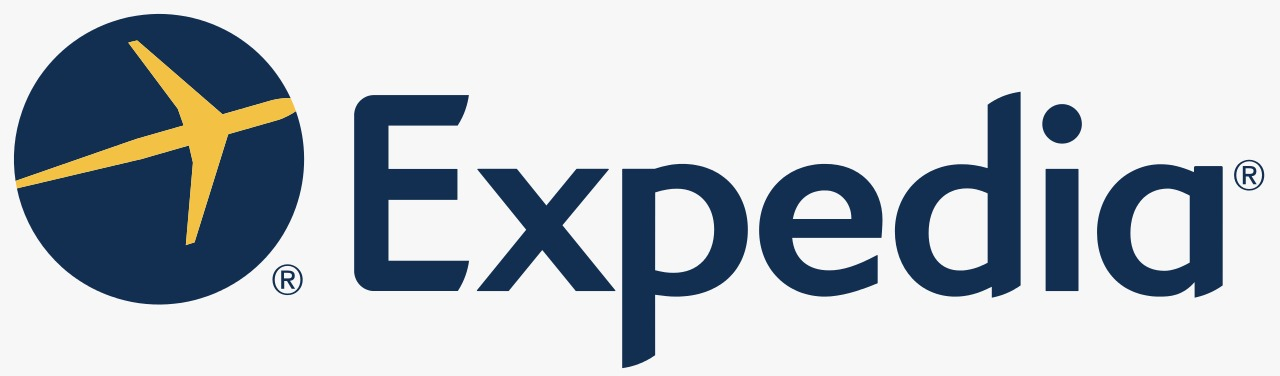

In [1]:
from IPython.display import Image
Image("logo.jpeg")

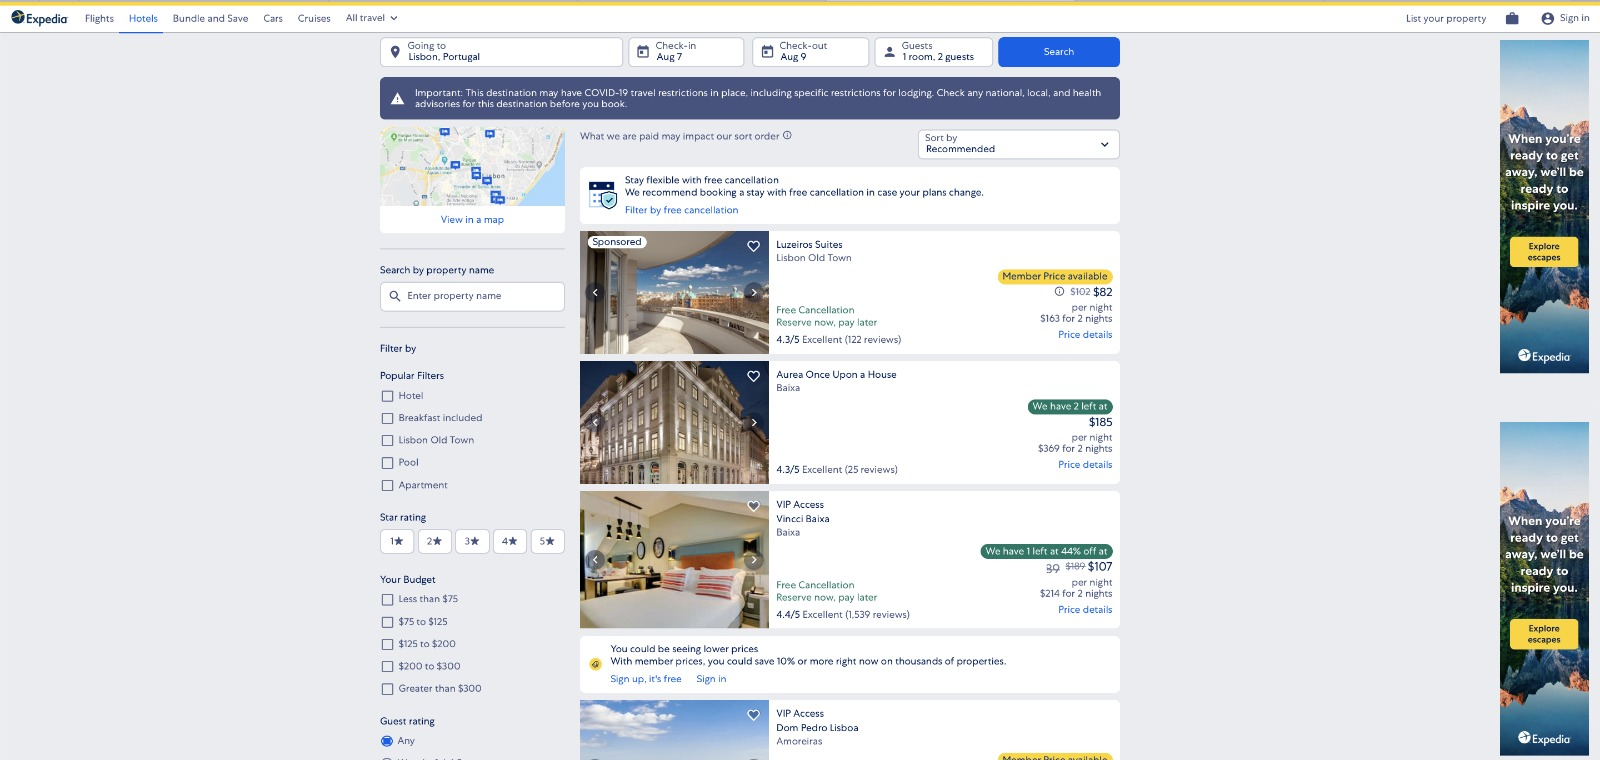

In [2]:
Image("webpage.jpeg")

## 1. The Expedia business problem

### What does Expedia need machine learning for?
Expedia is an online travel shopping company, it main operations concern the aggregation of travel fee data. As such, users visiting its website perform search queries and based on the user input, hotels are recommended. In a next step, Expedia wants to improve its generic search algorithm and apply machine learning to provide user specfic hotel recommendations.<br>
Firstly, the dataset provided can be described as large, the training set containing 37 million rows. Each row contains 24 features. Despite, there are no clear rules nor easily detectable patterns on how users choose between different hotel clusters. Summarizing it is a complex problem, with large amounts of data and features, which justifies the use of machine learning.
<br>
### What problem needs to be solved?
Expedia is a travel platform that allows hotel reservations and aims to provide personalized recommendations for users. Currently, Expedia uses search parameters to tailor recommendations, but they are not user specific enough. The success of Expedia is dependent on the number of bookings made. The better the hotel recommendations, the more likely is a user to book with Expedia. Therefore, it is of a foremost interest for Expedia to make the best possible predictions for users, finalize bookings, and consequently generate revenues.
Given that there are hundreds of millions of visitors every month, and the recommendations have to be made instantaneous, it is not a small task but the rewards, also in terms of additional revenue, can be tremendous.
Expedia provides the data from all the users in the logs including clicking events as well as booking events. This task at hand is to contextualize the customer data and predict the likelihood of a user staying in one out of 100 different hotel clusters. Consequently, users could be presented hotels from the most likely hotel cluster, hopefully increasing the conversion rate.
<br>
### Is suffcient data available?
We only use a part (500000 observations) of the provided training set containing one million rows, due to limited computing resources. For now, we will assume that results generalize to the complete dataset. As we are using supervised learning techniques we need labeled data. The provided test set only contains unlabeled data, therefore, we decided the training set into train, validation and test set.
<br>
Also, given the data comes directly from the logs, its reasonable to assume that it is high quality data.

## 2. Expedia EDA

First, we will start by exploring the data and look for patterns as well as meaningful representations of features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from plotnine import *

In [2]:
df_train_eda = pd.read_csv('data/train.csv', nrows=500000)

**Data processing**

The collected data needs some processing to be able to work with, especially the time-related columns. 
Additionally, some features are generated which we expect to helpful in exploring patterns.

In [3]:
df_train_eda["date_time"] = pd.to_datetime(df_train_eda["date_time"]) # convert to date time object
df_train_eda["year"] = df_train_eda["date_time"].dt.year  # select only the year 
df_train_eda["month"] = df_train_eda["date_time"].dt.month  # select only the month
df_train_eda["day"]= df_train_eda["date_time"].dt.day  # select only the day
df_train_eda["hour"]= df_train_eda["date_time"].dt.hour # select only the hours 

dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
# map the day and associate the name of the weekday
df_train_eda["day_name"]=df_train_eda["date_time"].dt.dayofweek.map(dayOfWeek)  

# create a new feature if the traveler booked for 1 adult only
df_train_eda['solo_trip'] = np.where(((df_train_eda['srch_adults_cnt'] == 1) & (df_train_eda['srch_children_cnt'] == 0)), 1, 0)
# create a time stamps feature for check in day
df_train_eda['srch_ci']=pd.to_datetime(df_train_eda['srch_ci'],infer_datetime_format = True,errors='coerce')
# create a time stamps feature for check out day
df_train_eda['srch_co']=pd.to_datetime(df_train_eda['srch_co'],infer_datetime_format = True,errors='coerce')
# create a new feature if the booking hotel is in the same country as user location
df_train_eda['is_same_country'] = np.where(df_train_eda['user_location_country'] == df_train_eda['hotel_country'], 1, 0)

# reate a new feature about how much time earlier the customers plan the trip
df_train_eda['plan_time'] = ((df_train_eda['srch_ci']-df_train_eda['date_time'])/np.timedelta64(1,'D')).astype(float)
# reate a new feature about how many nights the customers spend in the hotel
df_train_eda['hotel_nights']=((df_train_eda['srch_co']-df_train_eda['srch_ci'])/np.timedelta64(1,'D')).astype(float)

# get day of the week
df_train_eda['srch_ci_w'] = df_train_eda['srch_ci'].dt.dayofweek
df_train_eda['srch_co_w'] = df_train_eda['srch_co'].dt.dayofweek

# weekday if check-in before or on Thursday and Check-out before or on Friday
df_train_eda['is_weekend_trip'] = np.where((df_train_eda['srch_ci_w'] < 4) & (df_train_eda['srch_co_w'] <= 4), 0, 1)


# monthly statistics for booking events
monthly_number_stats_booking_train = (df_train_eda[df_train_eda["is_booking"]==1].groupby(["year", "month"])["is_booking"].count())
# monthly statistics for click events
monthly_number_stats_click_train = (df_train_eda[df_train_eda["is_booking"]==0].groupby(["year", "month"])["is_booking"].count())

###  a. Bookings and Clicks per Month
The graph below shows the number bookings and clicks for all months included in the dataset. It can be seen that there is a slight increase in both clicks and bookings over time. Also it can be seen that the winter months seem to generate less traffic than the summer months. However, this is difficult to verfiy since the data is only from two years so patterns regarding time are not very reliable.

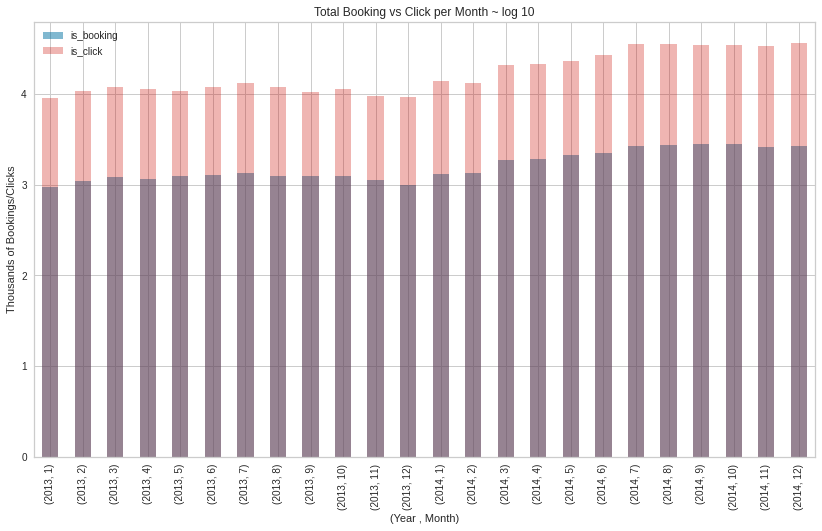

In [84]:
fig = np.log10(monthly_number_stats_booking_train).plot(kind='bar', alpha=0.5, figsize=(14, 8))
np.log10(monthly_number_stats_click_train).plot(kind='bar', alpha=0.3, color = 'r', figsize=(14, 8), label="is_click")
fig.legend()
fig.set_title("Total Booking vs Click per Month ~ log 10")
fig.set_ylabel("Thousands of Bookings/Clicks")
fig.set_xlabel("(Year , Month)" )
plt.show()

### b. Distribution of hotel clusters
The data set includes predefined hotel clusters, which is the target variable. The hotels are assigned to clusters that shall be predicted for each individual customer to recommend the right hotels in order to generate bookings. There are 100 different clusters. The graph shows that the amount of clicks per hotel cluster in the train set is distributed relatively even, which helps to train machine learning models on the data. Also, the graph shows that some clusters are much more clicks than the others meaning that the clicks are not evenly distributed among hotel clusters.

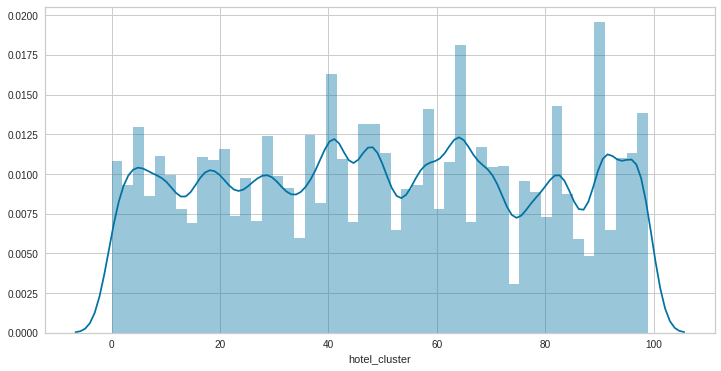

In [87]:
plt.figure(figsize=(12, 6))
sns.distplot(df_train_eda['hotel_cluster'])
plt.show()

### c. Bookings and Clicks per Weekdays
The graph below shows the relationship of bookings and clicks by the day of the week. It can be seen that on working days there are more clicks and bookings than during the weekend suggesting that people prefer to search and book their trips over the weekdays. In general the day seems to be a decisive variable for booking and clicks since the amount of bookings is double as high at their peak on Wednesday compared to the lowest number of bookings on Saturday.

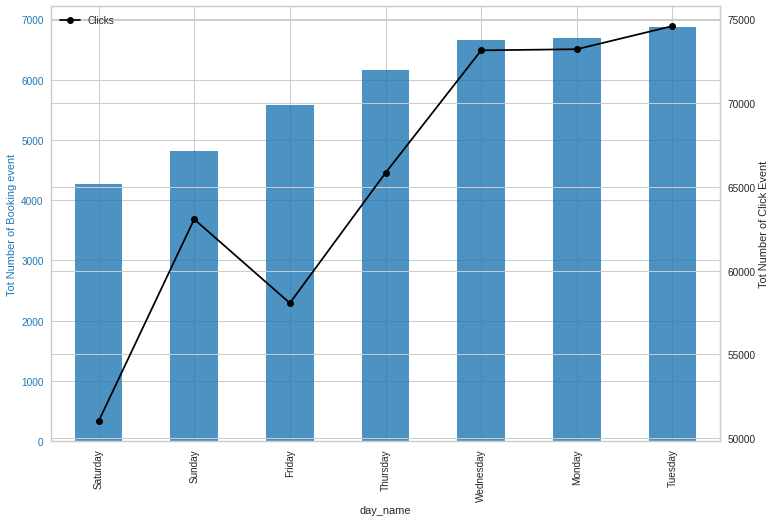

In [89]:
# total number of booking events sorted by weekdays
tot_n_user_booking=df_train_eda[df_train_eda.is_booking==1].groupby("day_name")['user_id'].count().sort_values()
# total number of click events sorted by weekdays
tot_n_user_click=df_train_eda[df_train_eda.is_booking==0].groupby("day_name")['user_id'].count().sort_values()

fig, ax1 = plt.subplots(figsize=(12, 8))
color = 'tab:blue'
ax1.set_ylabel('Tot Number of Booking event',color=color)
ax1.set_xlabel('Day of the Week')
ax1.tick_params(axis='y', labelcolor=color)

pd.DataFrame(tot_n_user_booking)["user_id"].plot(kind='bar',color=color,ax=ax1,alpha=0.8)

ax2 = ax1.twinx()
ax2.set_ylabel('Tot Number of Click Event')
pd.DataFrame(tot_n_user_click, index=tot_n_user_booking.index)["user_id"].plot(kind='line', marker='o', color="black", 
                                                                  ax=ax2,secondary_y=False,label="Clicks")

plt.legend(loc="best")
plt.show()

### d. Recurring Bookings
The graph below shows how often customers booked via Expedia. It can be seen that most of the users only booked once in the available time frame. Also it can be seen that few users booked more than 10 times, which seems reasonable within only two years.

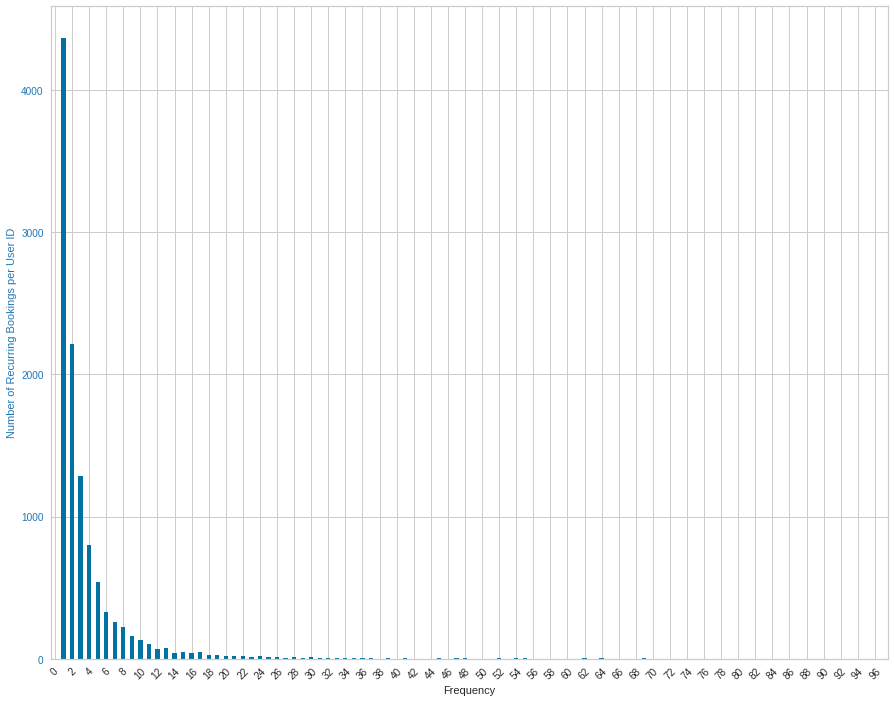

In [90]:
# total number of booking events sorted by frequency
df_train_book = df_train_eda[df_train_eda['is_booking'] == 1]
df_train_bookings = df_train_book.groupby('user_id')['is_booking'].count().value_counts()

zeros = pd.Series(np.zeros(int(df_train_bookings.index.max())))
booking_freq = pd.concat([df_train_bookings, zeros], axis = 1)['is_booking'].fillna(0)


fig, ax1 = plt.subplots(figsize=(15,12))

booking_freq.plot(kind = 'bar', figsize = (15,12))
color = 'tab:blue'
ax1.set_ylabel('Number of Recurring Bookings per User ID',color=color)
ax1.set_xlabel('Frequency')
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_ticks(np.arange(0, len(booking_freq+1), 2))
ax1.set_xticklabels(np.arange(0, len(booking_freq+1), 2))
ax1.tick_params(axis='x', rotation = 45)

### e. Bookings per Website
The graph below shows how often customers booked via the different country domain of Expedia's website. It can be seen that most of the users come from the country location domain code number 2 regarding both booking and click events. Although the scale of the data was normalized using LOG 10, there is a clear peak of the country domain 2 respect the second most used number 37.

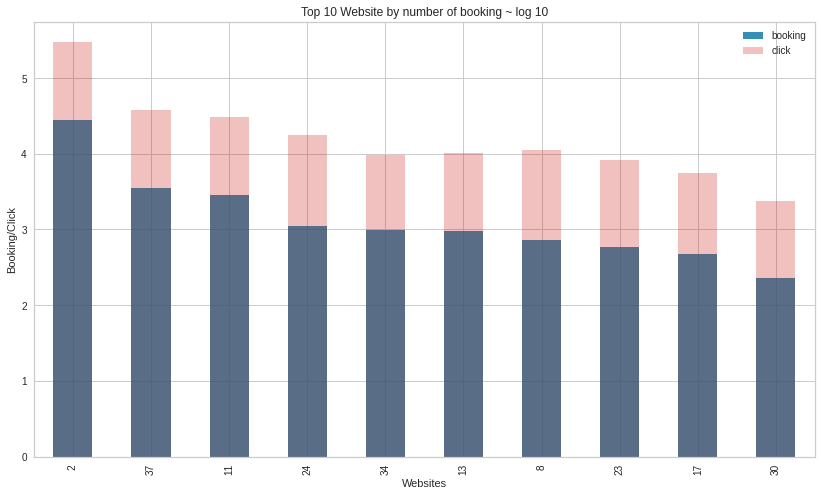

In [92]:
# website statistics for booking events
website_loc_booking=df_train_eda[df_train_eda.is_booking==1].groupby("site_name")['user_id'].count().sort_values(ascending=False)
# website statistics for click events
website_loc_click=df_train_eda[df_train_eda.is_booking==0].groupby("site_name")['user_id'].count().sort_values(ascending=False)
website_loc_stat=pd.concat([website_loc_booking,website_loc_click],axis=1)
website_loc_stat.columns=["booking","click"]
website_loc_stat.sort_values(ascending=False, by="booking", inplace=True)

# log10 normalization
fig = np.log10(website_loc_stat[:10]["booking"]).plot(kind='bar', alpha=0.8, figsize=(12, 6))
np.log10(website_loc_stat[:10]["click"]).plot(kind='bar', alpha=0.25, color = 'r', figsize=(14, 8), label="click")
fig.legend()
fig.set_title("Top 10 Website by number of booking ~ log 10")
fig.set_ylabel("Booking/Click")
fig.set_xlabel("Websites" )
plt.show()

### f. Share of Packages
Attention, this statistics represents only the small train set we analysis, it might be really different for the entire train set.

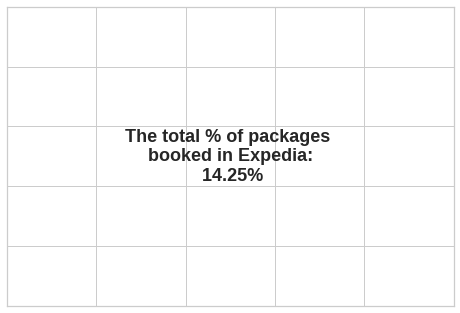

In [94]:
prctg_package_booking= df_train_eda[(df_train_eda.is_booking==1)&(df_train_eda.is_package)==1]["user_id"].count()/df_train_eda[df_train_eda.is_booking==1]['user_id'].count()
round(prctg_package_booking*100,2)

fig, ax = plt.subplots()

ax.text(0.5, 0.5, 'The total % of packages \n booked in Expedia: \n {}%'.format(round(prctg_package_booking*100,2)), 
        size=18, ha='center', va='center',weight='bold')
plt.tick_params( axis='both', which='both',bottom=False, top=False, labelbottom=False, left=False, labelleft=False)

### g. Top 4 hotel cluster characteristics ( for booking event only) 
In order to plot the chart below the top 4 hotel clusters (28,42,48,91) we sorted them respect the total number of guests hosted. As it shows below, the features of solo_trip (the traveler did a solo trip), is_mobile (the booking was made throughout Expedia app), and is_package (The traveler booked a package ie. hotel+flight) do not represent a meaningful portion of total booking event. So most likely those features will be dropped from the feature engineering selection later.

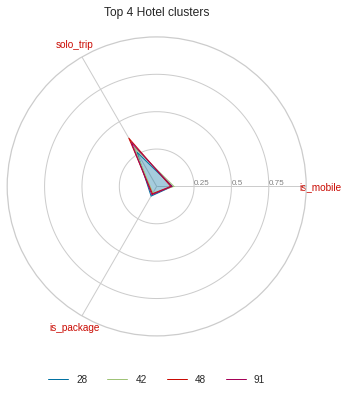

In [97]:
# statistics per hotel cluster grouped by adult + children
top_visted_hotel_cluster=df_train_eda[(df_train_eda.is_booking==1)].groupby("hotel_cluster")["srch_adults_cnt","srch_children_cnt"].sum()
# count total number of guests booked for each hotel cluster
top_visted_hotel_cluster["tot_visitor"]=top_visted_hotel_cluster.srch_adults_cnt+top_visted_hotel_cluster.srch_children_cnt
# select the top 4 cluster
top_4_visited_hotel_cluster=top_visted_hotel_cluster.sort_values(by="tot_visitor",ascending=False)[:4]
top4_visited=top_4_visited_hotel_cluster.index
top_4_visited_hotel_cluster=df_train_eda[(df_train_eda.is_booking==1)&(df_train_eda.hotel_cluster).isin(top4_visited)]

# pivot table % of mobile booking
hotel_cluster_is_mobile=round((pd.pivot_table(top_4_visited_hotel_cluster,values=["user_id"],
                    index=['hotel_cluster',"is_mobile"], aggfunc='count')/pd.pivot_table(top_4_visited_hotel_cluster,values=["user_id"],index=['hotel_cluster'], aggfunc='count')),4)
hotel_cluster_is_mobile.reset_index(inplace=True)
hotel_cluster_is_mobile=hotel_cluster_is_mobile[hotel_cluster_is_mobile.is_mobile==1]
# pivot table % of package booking
hotel_cluster_is_package=round((pd.pivot_table(top_4_visited_hotel_cluster,values=["user_id"],
                    index=['hotel_cluster',"is_package"], aggfunc='count')/pd.pivot_table(top_4_visited_hotel_cluster,values=["user_id"],index=['hotel_cluster'], aggfunc='count')),4)
hotel_cluster_is_package.reset_index(inplace=True)
hotel_cluster_is_package=hotel_cluster_is_package[hotel_cluster_is_package.is_package==1]
# pivot table % of solo trip booking
hotel_cluster_solo_trip=round((pd.pivot_table(top_4_visited_hotel_cluster,values=["user_id"],
                    index=['hotel_cluster',"solo_trip"], aggfunc='count')/pd.pivot_table(top_4_visited_hotel_cluster,values=["user_id"],index=['hotel_cluster'], aggfunc='count')),4)
hotel_cluster_solo_trip.reset_index(inplace=True)
hotel_cluster_solo_trip=hotel_cluster_solo_trip[hotel_cluster_solo_trip.solo_trip==1]



hotel_cluster_is_mobile["solo_trip"]=hotel_cluster_solo_trip["user_id"]
hotel_cluster_is_mobile["is_package"]=hotel_cluster_is_package["user_id"]
hotel_cluster_is_mobile.drop("is_mobile",axis=1,inplace=True)
hotel_cluster_is_mobile.columns=['hotel_cluster',"is_mobile",'solo_trip','is_package']

categories=list(hotel_cluster_is_mobile)[1:]

N = len(categories)

values = hotel_cluster_is_mobile.iloc[0].drop('hotel_cluster').values.flatten().tolist()
values1 = hotel_cluster_is_mobile.iloc[1].drop('hotel_cluster').values.flatten().tolist()
values2 = hotel_cluster_is_mobile.iloc[2].drop('hotel_cluster').values.flatten().tolist()
values3 = hotel_cluster_is_mobile.iloc[3].drop('hotel_cluster').values.flatten().tolist()

values += values[:1]
values1 += values1[:1]
values2 += values2[:1]
values3 += values3[:1]

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='r', size=10)
ax.set_rlabel_position(0)
#ax.yaxis.grid(False)
plt.yticks([0.25,0.5,0.75], ["0.25","0.5","0.75"], color="grey", size=8)
plt.ylim(0,1)
plt.title("Top 4 Hotel clusters")
#plot
ax.plot(angles, values, linewidth=1, linestyle='solid', label="28")
ax.fill(angles, values, 'b', alpha=0.1)
ax.plot(angles, values1, linewidth=1, linestyle='solid', label="42")
ax.fill(angles, values1, 'b', alpha=0.1)
ax.plot(angles, values2, linewidth=1, linestyle='solid', label="48")
ax.fill(angles, values2, 'b', alpha=0.1)
ax.plot(angles, values3, linewidth=1, linestyle='solid', label="91")
ax.fill(angles, values3, 'b', alpha=0.1)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),
      fancybox=True, shadow=True, ncol=4)
plt.show()

### h. Correlation Heatmap
The heatmap shows that the correlations of the variables in the data set are relatively low regarding the target variable hotel_cluster. The highest correlation of hotel_cluster is 0.047 with hotel_market. Also the other variables do not really correlate. Only variables like website and continent or solo trip and adults count correlate which is quite obvious.

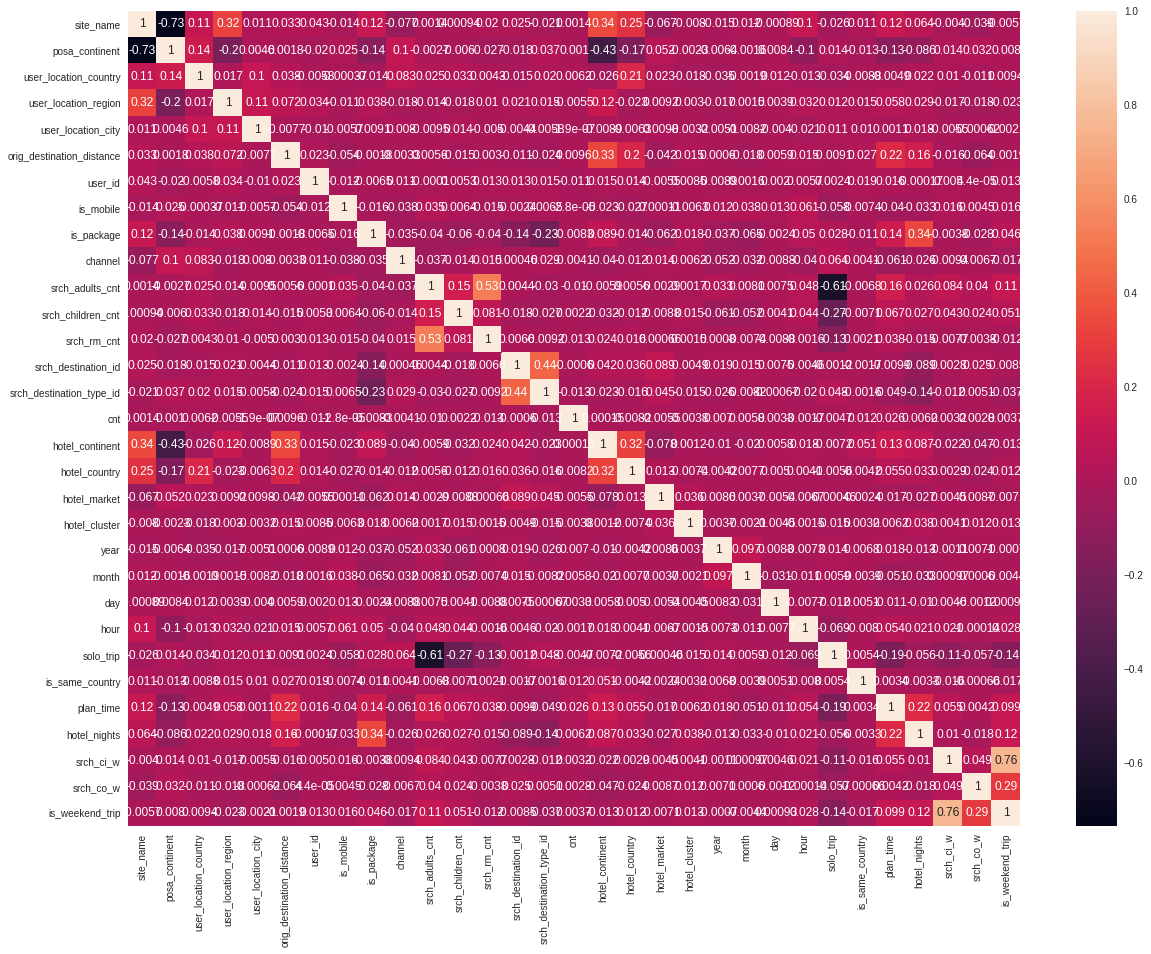

In [98]:
bookings=df_train_eda[df_train_eda["is_booking"]==1]
bookings.drop(["is_booking"], axis=1, inplace=True)
#fill orig_destination_distance with mean of the whole or mean of the same orig_destination pair
m=bookings.orig_destination_distance.mean()
bookings['orig_destination_distance']=bookings.orig_destination_distance.fillna(m)
# Since we extract the plan_time from srch_ci and date_time, we drop date_time and srch_ci
# we extract how many nights of stay, so we drop srch_co
lst_drop=['date_time','srch_ci','srch_co']
bookings.drop(lst_drop,axis=1,inplace=True)

plt.figure(figsize=(20,15))
corrMatrix=bookings.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### i. Origin Continent and Month
There seems to be a pattern between continet and booking events within different months. Apperently, from the 6th month of the year there is a higher demand on Expedia Website probably because of holiday season.

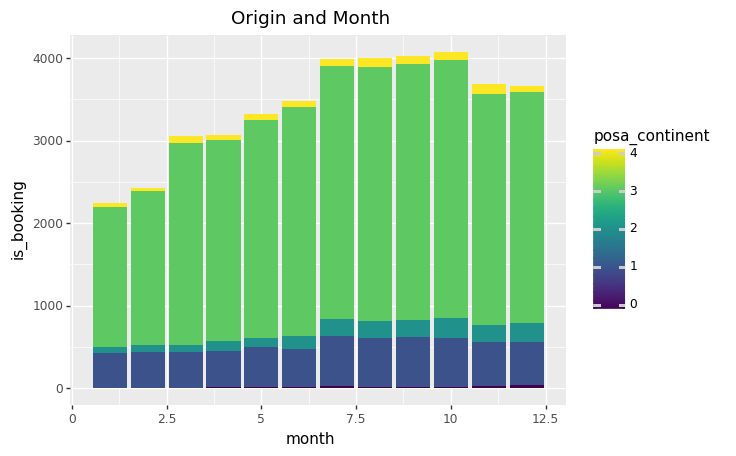

<ggplot: (280297009)>

In [4]:
month_continent = df_train_eda.groupby(['month', 'posa_continent']).agg({'is_booking':'sum'}).reset_index()

ggplot(month_continent, aes(x= 'month', y='is_booking', fill='posa_continent')) +\
    geom_bar(position ='stack', stat="identity") + ggtitle("Origin and Month")

### Does the problem show a regular pattern? 
From the EDA, we have seen that some hotels clusters are more popular than others. In general, Expedia customers prefer to book during weekdays. The figure d. “Recurring Booking” shows that few users are booking more than ten times, thus this implies that our predictions cannot only leverage past bookings as user data but also needs to incorporate other user specific data, such as possibly the clicking events. <br>
From the EDA, figure i. “Origin Continent and Month” shows a clear boom on booking event start from June. As well, from figure c. “Bookings and Clicks per Weekdays” we can see a increase of frequency of booking and click events on the Expedia website during the working days and lower activity during the weekend. Finally, from figure b. "Distribution of hotel clusters" we can observe that the frequency of our predicted variable hotel_cluster is balanced. 
<br>
All in all, there are no easily detectable regular patters capturing how customers choose their preferred hotels, but there seem to be relations, emphasizing the need for machine learning models.
<br>
### Can we find meaningful representations of the data?
Yes, the Data Visualization analysis generates several interisting insights. We plot meaningful representation which help us to understand our data. We found that our target variable is balanced which facilitates training, we encountered the difference in booking during working days and weekend as well, which made us to create the new features weekend_trip and business_trip.
<br>

### How is success defined? By what metric is success defined?
We define success in this multi class problem by measuring the accuracy of our models. Therefore, we recommend using the model that achieves the highest accuracy on the validation set. This is because we want to find a single hotel cluster to propose to a customer when he is visiting the website. The proposed hotel cluster in that case will either be right or wrong (being the one she actually booked), but there is no such thing as being more or less correct as all hotel clusters are similar (cluster 2 is not more similar to cluster 1 than cluster 100).<br>
Another approach we considered but did not implement is the Mean Average Precision @ k (e.g. when k=5 => MAP5). This is using the precision at cutoff k. Therefore the model needs to be tweaked as to return e.g. 5 recommendations ranked from 1 to 5 and then the MAP5 score would be assigned depending on the rank of the correct prediction. We do not include this metric because we prefer to only predict one class, but for further examination it could be an interesting metric.

## 3. The Expedia pipeline

In [2]:
import os
os.environ['NUMEXPR_MAX_THREADS']='16'

In [3]:
import pandas as pd
import shutil
import gzip
import zipfile
import sys
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import cross_val_score, ShuffleSplit, learning_curve, KFold
from sklearn.tree import plot_tree
from yellowbrick.model_selection import LearningCurve
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import EarlyStopping
import urllib.request
import os
import itertools
import time
import seaborn as sns
from pathlib import Path
import pandas as pd
import configparser
import numpy as np
import logging
from abc import abstractmethod
from sklearn.pipeline import Pipeline
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
import gc
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
import warnings
import tensorflow as tf

warnings.simplefilter('ignore')
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### 3.0 Setup

First of all, the test set provided by Expedia is unlabeled why we decided not to use any of the data. The Expedia train dataset is pretty large on its own with 37670293 rows in the train set. Thefore we set up some configurations below which specify how to many rows to load. The data loaded from train.csv is then split into train, valid and test.

In [4]:
# Load configs
config = configparser.ConfigParser()

config['General'] = {'path': '/home/jupyter/expedia', 
                    'is_development': True, # If false all rows are read into memory
                    'use_test': False, # usually do not set this to true, the provided test set is unlabeled
                    'cross_validation': False, # Usually do not set this to true the data set is big enough using val set
                    }

config['Data'] = {'csvs': 'train.csv, test.csv, destinations.csv', # csv file names
                  'gzs': '2013-2014.gz, 2015.gz, destinations.csv.gz', # gzs file names
                  'url': 'https://www.dropbox.com/s/gwrc8o99xcj6r72/Expedia.zip?dl=1', # dropbox link
                  'write_sample_files': True, # whether to save files with only n rows
                  'remove_after_run': False, # whether to remove the data after run
                  'train_rows': 500000, # how many train rows ti use
                  'test_rows': 100, # how many test tows to use
                 }

config['Features'] = {'save_prepared': True, # whether to save the data after feature generation
                      'use_prepared': False, # when a file with with generated features has been prepared it can be loaded
                     }

config['Models'] = {'cvFolds': 8, # folds to use
                    'scoring': 'accuracy' # metric to evaluate
                   }

In [5]:
# configure logger
logging.basicConfig(stream=sys.stdout, 
                    level=logging.INFO, 
                    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")
logger = logging.getLogger('pipeline')

### 3.1 Data

The data class simply download the data provided in the dropbox unzips the gzip and zip files and locates the data in a suitable folder structure. If data already exists it simply returns.

In [6]:
class Data():
    def __init__(self, config):
        self.project_path = config.get('General', 'path')
        self.data_path = self.project_path + '/data/'
        self.url = config.get('Data', 'url')
        self.csvs = config.get('Data', 'csvs').split(', ')
        self.gzs = config.get('Data', 'gzs').split(', ')
        self.is_development = 'True' == config.get('General', 'is_development')
        self.write_sample_files = 'True' == config.get('Data',
                                                       'write_sample_files')
        self.train_rows = config.getint('Data', 'train_rows')
        self.test_rows = config.getint('Data', 'test_rows')
        self.remove_after_run = config.getboolean('Data', 'remove_after_run')
        self.logger = logging.getLogger('pipeline.run.data')

    def download_data(self):
        """
        Download files from dropbox
        """
        os.chdir(self.project_path)

        if all(os.path.isfile(self.data_path + csv) for csv in self.csvs):
            self.logger.info('Data already loaded')
        else:
            # if files not there yet init download it and write it as zip
            if not os.path.isfile('Expedia.zip'):
                self.logger.info('Downloading Expedia.zip from Dropbox...')
                u = urllib.request.urlopen(self.url)
                data = u.read()
                u.close()

                with open('Expedia.zip', 'wb') as f:
                    f.write(data)
                self.logger.info('Finished downloading Expedia.zip from Dropbox')

            # Extract gz files from zip
            with zipfile.ZipFile("Expedia.zip", 'r') as zip_ref:
                self.logger.info('Unzipping Expedia.zip')
                zip_ref.extractall(self.project_path)
                self.logger.info('Finished unzipping Expedia.zip...')

            os.chdir(self.project_path + '/all')

            # extract the csvs from the gzs
            for csv, gz in zip(self.csvs, self.gzs):
                with gzip.open(gz, 'rb') as f_in:
                    with open(csv, 'wb') as f_out:
                        self.logger.info(f'writing {csv}...')
                        shutil.copyfileobj(f_in, f_out)
                        self.logger.info(f'Finished writing {csv}')

            # clean up directory
            for f in self.gzs:
                os.remove(f)

            os.chdir(self.project_path)  # return to parent directory
            # if the data directory already exists probably empty, remove it
            if os.path.exists(self.data_path):  #
                shutil.rmtree(self.data_path)
            os.rename(self.project_path + '/all', self.data_path)
            os.remove('Expedia.zip')

            self.logger.info('Finished loading data')

    def load_data(self):
        """
        Load the data into memory
        """
        self.logger.info('Loading data into memory / dataframe')
        if not self.is_development:
            df_train = pd.read_csv(self.data_path + self.csvs[0])
            df_test = pd.read_csv(self.data_path + self.csvs[1])
            # not even needed. its enough to have the destination id as feature
            df_destination = pd.read_csv(self.data_path + self.csvs[2])
        else:
            df_train = pd.read_csv(self.data_path + self.csvs[0],
                                   nrows=self.train_rows)
            df_test = pd.read_csv(self.data_path + self.csvs[1],
                                  nrows=self.test_rows)
            df_destination = pd.read_csv(self.data_path + self.csvs[2])

            if self.write_sample_files:
                self.logger.info('Writing sample files...')
                df_train.to_csv(self.data_path + 'sample' + self.csvs[0],
                                index=False)
                df_test.to_csv(self.data_path + 'sample' + self.csvs[1],
                               index=False)
                self.logger.info('Finished writing sample files...')

        self.logger.info('Finished loading data into memory / dataframe')
        self.df_train = df_train
        self.df_test = df_test
        self.df_destination = df_destination

        if self.remove_after_run:
            self.remove_data()

    def remove_data(self):
        """
        Remove the data from disk
        """
        self.logger.info('Removing files from hard drive...')
        cwd = os.getcwd()
        os.chdir(self.data_path)
        for csv in self.csvs:
            try:
                self.logger.info('Removing ', csv, '...')
                os.remove(csv)
            except EnvironmentError:
                self.logger.info(csv, ' not found.')
            try:
                self.logger.info('Removing sample ', csv, '...')
                os.remove('sample' + csv)
            except EnvironmentError:
                self.logger.info('sample', csv, ' not found.')
        os.chdir(cwd)
        self.logger.info('Finished removing files from hard drive...')

If, during the configuration it was specified to use a csv which holds the prepared features, the data download can be skipped

In [7]:
# Load the data
if not config.getboolean('Features', 'use_prepared'):
    logger.info('Loading and preparing data')
    d = Data(config)
    d.download_data()
    d.load_data()

2020-05-11 17:26:58,102 - pipeline - INFO - Loading and preparing data
2020-05-11 17:26:58,167 - pipeline.run.data - INFO - Unzipping Expedia.zip
2020-05-11 17:27:12,474 - pipeline.run.data - INFO - Finished unzipping Expedia.zip...
2020-05-11 17:27:12,476 - pipeline.run.data - INFO - writing train.csv...
2020-05-11 17:27:33,458 - pipeline.run.data - INFO - Finished writing train.csv
2020-05-11 17:27:33,460 - pipeline.run.data - INFO - writing test.csv...
2020-05-11 17:27:35,504 - pipeline.run.data - INFO - Finished writing test.csv
2020-05-11 17:27:35,505 - pipeline.run.data - INFO - writing destinations.csv...
2020-05-11 17:27:36,172 - pipeline.run.data - INFO - Finished writing destinations.csv
2020-05-11 17:27:36,353 - pipeline.run.data - INFO - Finished loading data
2020-05-11 17:27:36,354 - pipeline.run.data - INFO - Loading data into memory / dataframe
2020-05-11 17:27:39,192 - pipeline.run.data - INFO - Writing sample files...
2020-05-11 17:27:42,332 - pipeline.run.data - INFO 

### 3.2 Feature Enginneering


Using our domain knowledge we have generated and deleted features in order to make our machine learning algorithms work better and hopefully improve accuracy.

First of all, from the difference of check-out and check-in date we got the trip length feature. And also, we saw that as the duration increases, certain hotel clusters are preferred over others and so we have created a dummy feature whether the trip was shorter than 3 days or not.

Also, customers when travelling inside their own countries tend to have more knowledge about sites and different preferences so we created a dummy whether the trip is domestic. 

Everyone who has ever worked in a big corporation already knows that, when making business travels budget and locations are very different when doing leisure travels with friends. Therefore, to differentiate between them by creating two dummies – the weekend_trip and business trip one (trips are classified as business trips if the trip start and ends within a working week).
 
Also, when travelling as family, with children, we look for very different amenities inside a hotel or attractions close by than when travellling alone. Thus, we made the solo_trip dummy. 

Also, we created the booking_rate feature that captures the effect of how many searches a user has made before a booking previously and a plan_time feature capturing how many days ahead he is planning the trip. 

Finally, but probably the most importantly. As our data includes all the events a user does until booking, and there are much more click events than booking, we have aggregated all this information from previous bookings and clicks per hotel cluster, giving us additional 200 columns – for each hotel cluster out of 100, there are two columns – one with the count of bookings and the other with the count of clicks.

On the other hand, we have deleted date-time feautre as we have already extracted the important information by creating other features that were just mentioned. The very same applies to the check-in and check out. And finally, we deleted the user ID, following the general machine learning practice.

It is important to note that the feature generation step reduces the size of the dataset signifcantly. In the case at hand, the data set length drops from 500000 to ~30000. Most of the provided data encompasses click data not booking events. As machine learning models require us to provide a fixed length feature vector (RNNs may pose an exeption), we aggregate all the click events of a user in a single booking row, trying to collapse her past user activities in the 200 features described previously. As a side note it should be noted that doing so is computationally expensive as the operations to aggregate previous info cannot be vectorized. A very different approach would be to simply drop the data which does not represent a booking but we believe that user histories are the most valuable input we have.

In short:

**Added extra features:**
*	trip_length - Lenght of trip
*	short_trip – is the trip smaller than 3 days (dummy)
*	domestic - Is the trip in the same country (dummy)
*	weekend_trip – is it only a weekend trip (dummy)
*	business_trip – is it a business trip (dummy)
*	solo_trip – whether travellin alone or with family (dummy)
*	booking_rate – captures how many clicks before booking (float)
*	plan_time – how far ahed do we plan the trip (int)
*	aggregate previous bookings & clicks by hotel cluster	

**Deleted unnecessery features:**
*	date_time – timestamp
*	srch_ci – check-in date
*	srch_co – check-out date
*	user_id - ID of user

The Features class is constructed only by taking in the configuration as well as the train and test data (usually only train as test is unlabeled) and prepare the features while trying to parallelize the process.

In [8]:
class Features():
    pipeline = Pipeline([('std_scaler', StandardScaler())])
    logger = logging.getLogger('pipeline.run.features')

    def __init__(self, config, df_train=None, df_test=None):
        self.config = config
        self.save_prepared = config.getboolean('Features', 'save_prepared')
        self.use_prepared = config.getboolean('Features', 'use_prepared')
        self.df_train = df_train
        self.df_test = df_test
        self.project_path = config.get('General', 'path')
        self.data_path = self.project_path + '/data/'
        self.logger = logging.getLogger('pipeline.run.features')

    def scale_features(X_train, X_holdout=None, X_test=None):
        """
        Scale the features, check which dfs are provided (test? holdout?)
        """
        Features.logger.info('Scaling Features')
        Features.pipeline.fit(X_train)

        if X_test is not None and X_holdout is None:
            return Features.pipeline.transform(X_train), Features.pipeline.transform(X_test)
        elif X_holdout is not None and X_test is not None:
            return Features.pipeline.transform(X_train), Features.pipeline.transform(X_holdout), Features.pipeline.transform(X_test)
        else:
            return Features.pipeline.transform(X_train)

    @staticmethod
    def fillna_convert(df):
        """Function to fill NANS and change time stamp foremats"""
        # filling empty orig_destianation distance
        df['orig_destination_distance'].fillna(
            df['orig_destination_distance'].median(), inplace=True)

        # make timestemps pd datetimes
        for col in df[['date_time', 'srch_ci', 'srch_co']].columns:
            df[col] = pd.to_datetime(df[col])

        return df

    @staticmethod
    def engineer_features(df, df_full):
        """
        Function to engineer features on the given df, aggregates user info
        from df_full
        """
        # length of trip
        df['trip_length'] = (df['srch_co'] - df['srch_ci'])\
            .astype('timedelta64[D]')
        df['trip_length'].fillna((df['trip_length'].median()), inplace=True)

        # is the trip in the same country
        df['domestic'] = np.where((df['user_location_country']
                                   .equals(df['hotel_country'])), 1, 0)

        # is it trip length smaller than 3 days
        df['short_trip'] = np.where((df['trip_length'] <= 3), 1, 0)

        #  is it a weekend trip
        df['srch_ci_d'] = df['srch_ci'].dt.day_name()
        df['srch_co_d'] = df['srch_co'].dt.day_name()
        df['weekend_trip'] = np.where((((df['srch_ci_d'] == 'Friday') &
                                        (df['trip_length'] <= 3)) |
                                       ((df['srch_ci_d'] == 'Saturday') &
                                        (df['trip_length'] <= 2))), 1, 0)

        # is it a business trip
        df['business_trip'] = np.where(((df['srch_ci_d'] != 'Friday') &
                                        (df['srch_ci_d'] != 'Saturday') &
                                        (df['srch_ci_d'] != 'Sunday') &
                                        (df['srch_co_d'] != 'Saturday') &
                                        (df['srch_co_d'] != 'Sunday') &
                                        (df['trip_length'] <= 4)), 1, 0)
        df.drop(columns=['srch_ci_d', 'srch_co_d'], inplace=True)

        # plan time - how far ahead do we plan the trip
        df['plan_time'] = (df['srch_ci'] - df['date_time'])\
            .astype('timedelta64[D]')

        # is it a solo trip / family trip
        df['solo_trip'] = np.where(((df['srch_adults_cnt'] == 1) &
                                    (df['srch_children_cnt'] == 0)), 1, 0)

        # aggregate a mean booking rate
        def aggregated_booking_rate(instance):
            if instance['is_booking'] == 0:
                return np.nan
            instance_date = instance['date_time']
            instance_id = instance['user_id']
            mean_booking_rate = df_full[(df_full['date_time'] <= instance_date)
                                        & (df_full['user_id'] == instance_id)
                                        ]['is_booking'].mean()
            return mean_booking_rate

        df['booking_rate'] = df.apply(aggregated_booking_rate, axis=1)

        # aggregate previous bookings & clicks by hotel cluster
        def aggregated_previous_cluster(instance, hotel_cluster):
            if instance['is_booking'] == 0:
                return np.nan, np.nan
            instance_date = instance['date_time']
            instance_id = instance['user_id']
            cnt_b = len(df_full[(df_full['date_time'] <= instance_date) &
                                (df_full['user_id'] == instance_id) &
                                (df_full['hotel_cluster'] == hotel_cluster) &
                                (df_full['is_booking'] == 1)])
            cnt_nob = len(df_full[(df_full['date_time'] <= instance_date) &
                                  (df_full['user_id'] == instance_id) &
                                  (df_full['hotel_cluster'] == hotel_cluster) &
                                  (df_full['is_booking'] == 0)])
            return cnt_b, cnt_nob

        for hotel_cluster in df_full['hotel_cluster'].unique():
            if np.isnan(hotel_cluster):  # test set does not have cluster given
                continue
            df['booked_cluster' + str(int(hotel_cluster))], \
                df['not_booked_cluster' + str(int(hotel_cluster))] = zip(
                *df.apply(lambda instance:
                          aggregated_previous_cluster(instance, hotel_cluster),
                          axis=1))

        return df

    @staticmethod
    def parallel_feature_engineering(df_to_split, df_full, n_cores=16):
        """Function to enable multi threading for feature engineering"""
        func = Features.engineer_features
        df_splits = np.array_split(df_to_split, n_cores)
        args = [[df_split, df_full] for df_split in df_splits]
        pool = Pool(n_cores)
        df = pd.concat(pool.starmap(func, args))
        pool.close()
        pool.join()
        return df

    @staticmethod
    def finalize(df):
        """Function removing features not needed for training"""
        for col in ['srch_ci', 'srch_co', 'user_id']:
            try:
                df.drop(col, axis=1, inplace=True)
            except KeyError:
                pass
        return df

    def prepare_df_train(self):
        """
        Function to build features for train df 
        => Keep in mind this data df is later split into df train, val and test if test not used
        """
        if self.use_prepared:
            self.df_train = pd.read_csv(self.data_path + 'prepared_train.csv')
            self.logger.info('Loaded prepared train data')

            # Warn config train len not the same as the prepared one
            self.logger.info(f'The train set length is {len(self.df_train)}')

            return
        
        self.logger.info('Prepare features for test')

        self.df_train = Features.fillna_convert(self.df_train)
        self.df_train = Features.parallel_feature_engineering(self.df_train,
                                                              self.df_train)
        self.df_train = Features.finalize(self.df_train)

        # only use rows where booking is 1 and aggregate all info
        len_before = len(self.df_train)
        self.df_train = self.df_train[self.df_train['is_booking'] == 1]
        self.df_train = self.df_train.drop('is_booking', axis=1)
        self.logger.info(f'Dropped {len_before - len(self.df_train)} rows which did not represent a booking in df train.')

        if self.save_prepared and not self.use_prepared:
            self.df_train.to_csv(self.data_path + 'prepared_train.csv')

    def prepare_df_test(self):
        """Function to build features for train df"""
        if self.use_prepared:
            self.df_test = pd.read_csv(self.data_path + 'prepared_test.csv')
            self.logger.info('Loaded prepared train data...')

            # Warn if config test len not the same as the prepared one
            if self.config.getint('Data', 'test_rows') != len(self.df_test):
                Features.logger.info('The loaded test data has a different len than\
                        given in the config')
            return

        self.df_test = Features.fillna_convert(self.df_test)
        df_train = Features.fillna_convert(self.df_train)

        # to engineer features on the test set we will concate test and train
        # and aggregate user info from train on test
        df_train['is_Train'] = True
        self.df_test['is_Train'] = False
        self.df_test['is_booking'] = 1
        self.df_test['hotel_cluster'] = np.nan
        df_test_full_hist = df_train.append(self.df_test)
        self.df_test = Features.parallel_feature_engineering(self.df_test,
                                                             df_test_full_hist)
        self.df_test = self.df_test.drop(['is_booking', 'is_Train',
                                          'hotel_cluster', 'id'], axis=1)
        self.df_test = Features.finalize(self.df_test)

        if self.save_prepared and not self.use_prepared:
            self.df_test.to_csv(self.data_path + 'prepared_test.csv')

In [9]:
# Feature preparation
logger.info('Feature preparation')
if not config.getboolean('Features', 'use_prepared'):
    logger.info('Loading and preparing data')
    f = Features(config, d.df_train, d.df_test)
else:
    logger.info('Loading prepared data')
    f = Features(config)

f.prepare_df_train()

try:
    f.df_train.drop('Unnamed: 0', axis=1, inplace=True)
except KeyError:
    pass

if config.getboolean('General', 'use_test'):
    f.prepare_df_test()

2020-05-11 17:27:42,385 - pipeline - INFO - Feature preparation
2020-05-11 17:27:42,387 - pipeline - INFO - Loading and preparing data
2020-05-11 17:27:42,388 - pipeline.run.features - INFO - Prepare features for test
2020-05-11 18:51:20,365 - pipeline.run.features - INFO - Dropped 458946 rows which did not represent a booking in df train.


In [10]:
# the features
f.df_train.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'is_mobile', 'is_package', 'channel',
       ...
       'booked_cluster87', 'not_booked_cluster87', 'booked_cluster31',
       'not_booked_cluster31', 'booked_cluster27', 'not_booked_cluster27',
       'booked_cluster23', 'not_booked_cluster23', 'booked_cluster74',
       'not_booked_cluster74'],
      dtype='object', length=228)

### 3.3 PCA

Given that we have created 228 features, it is important to consider dimensionality reduction, especially as it could possibly reduce the training time significantly. It turns out that there is not Elbow in the cumulative explained variance when increasing the number of dimensions. Therfore, we decided to stick with all feature for now.

In [11]:
class PCA_plots():
    def __init__(self, config, X):
        self.config = config
        self.X = X
    
    def __call__(self):
        """
        when called plot the explained variance per dimension as well as the
        cumulative explained variance against number of dimensions
        """
        scaled_data = StandardScaler().fit_transform(self.X)
        pca = PCA()
        pca.fit(scaled_data)
        pca_data = pca.transform(scaled_data)
        per_var = np.round(pca.explained_variance_ratio_ * 100, 1)
        labels = ['PC' + str(i) for i in range(1, (len(per_var)+1))]

        # Plot a scree graph
        plot_path = self.config.get('General', 'path') + '/plots'
        fig, ax = plt.subplots(1, 1, figsize=(40, 10))
        ax.bar(x=range(1, (len(per_var)+1)), height=per_var, tick_label=labels)
        ax.set_xticklabels(labels, rotation=90, ha="right")
        ax.set_ylabel('Percentage of explained variance')
        ax.set_xlabel('Principal component')
        ax.set_title('Scree plot')
        # fig.savefig(plot_path + '/pca_scree_test.png')
        plt.show()

        pca_df = pd.DataFrame(pca_data, columns=labels)
        loading_scores = pd.Series(pca.components_[0], index=self.X.columns)
        sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
        top_50_x = sorted_loading_scores[:50].index.values
        # print(pca.explained_variance_ratio_)
        # print(loading_scores[top_50_x])

        # How many dimensions do we need for 95% variance ratio
        cumsum = np.cumsum(pca.explained_variance_ratio_)
        d = np.argmax(cumsum >= 0.95) + 1
        # print(d)

        # Plot a scree graph with 95% cutoff
        fig, ax = plt.subplots(1, 1, figsize=(40, 10))
        ax.plot(labels, cumsum)
        ax.set_xlabel("Dimensions")
        ax.set_ylabel("Explained Variance")
        ax.grid()
        ax.plot([d, d], [0, 0.95], "k:")
        ax.plot([0, d], [0.95, 0.95], "k:")
        # fig.savefig(plot_path + '/pca_scree_test2.png')
        plt.show()

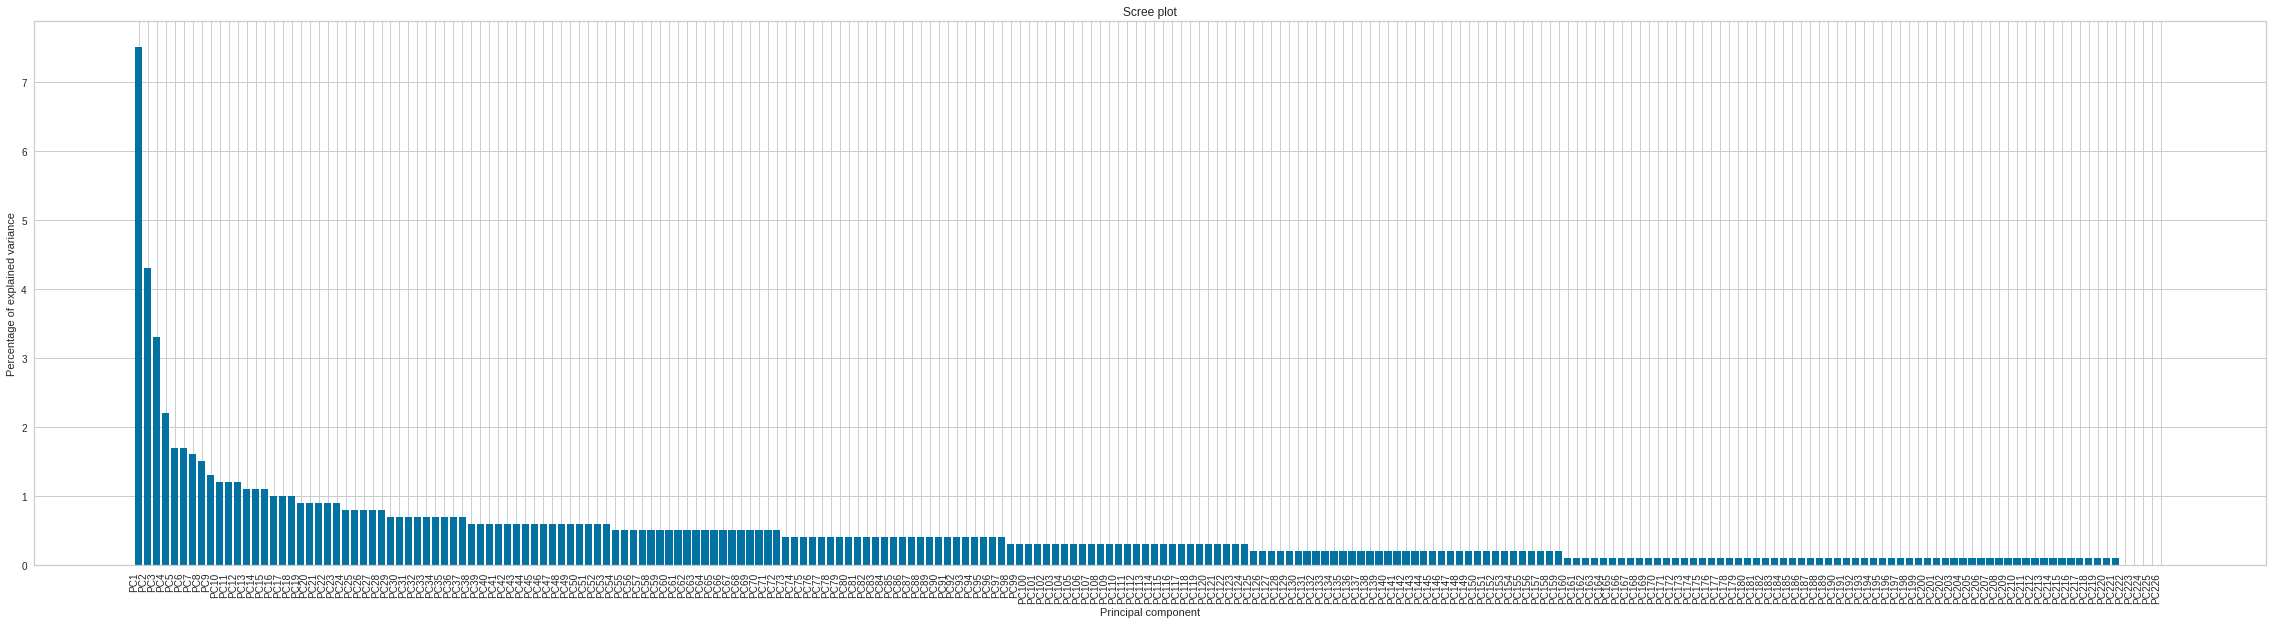

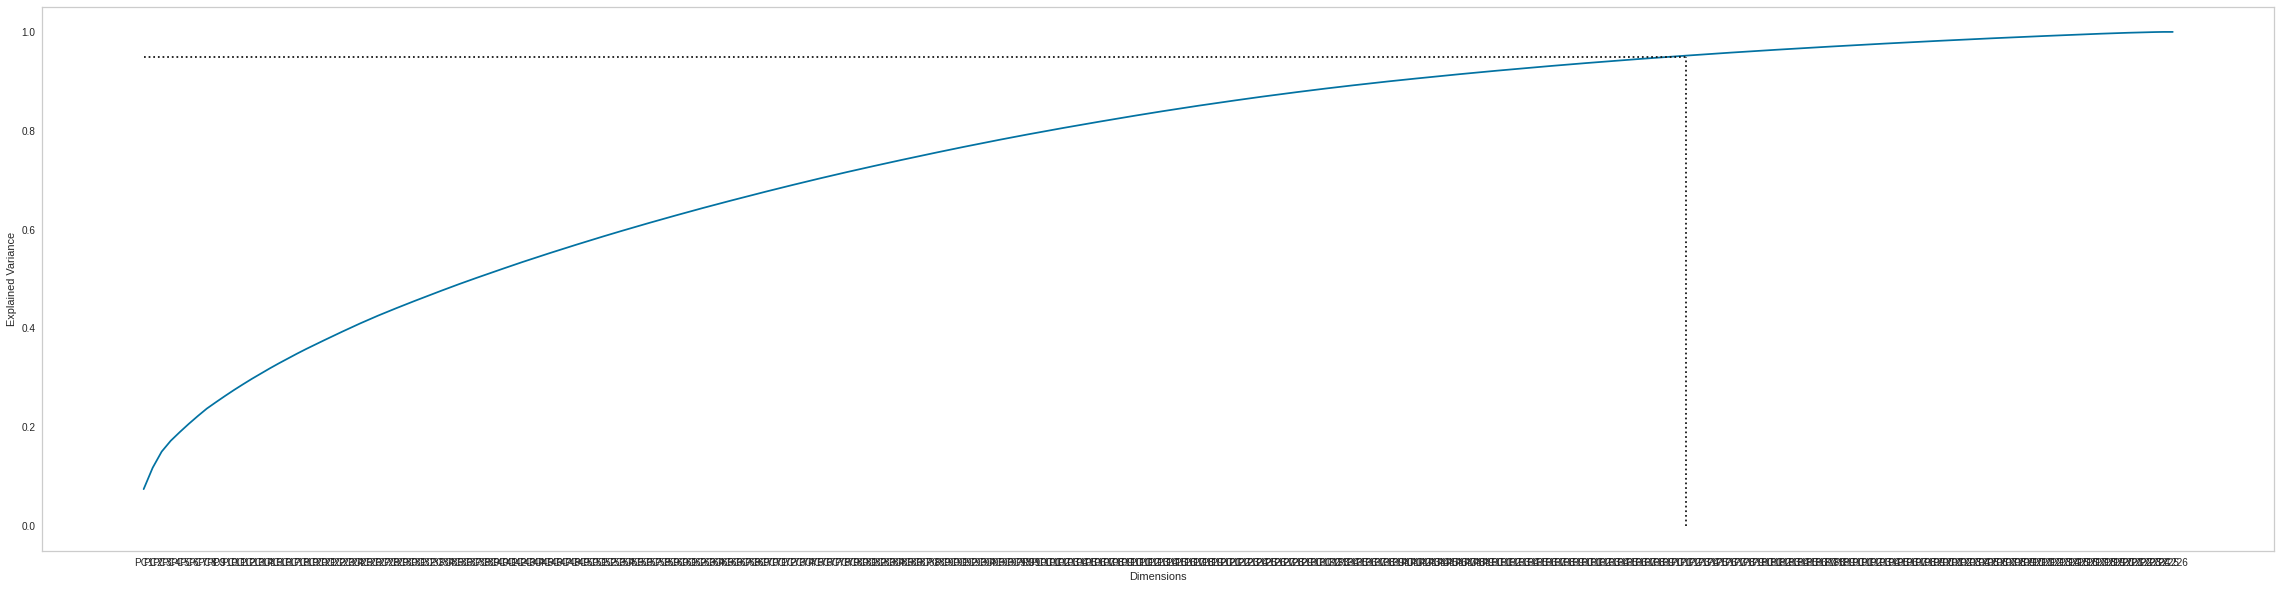

In [12]:
# perform PCA
PCA_plots(config, f.df_train.drop(['hotel_cluster', 'date_time'], axis=1))()

### 3.4 Models

We decided to train 4 machine learning models and one benchmark model.

* Benchmark model
* Decision tree
* Neural network
* Bagging: Random Forest
* Boosting: XGBoost

We want to store the model objects as well as the grid search results in a list to compare them in the end.

In [13]:
model_objects = []
grid_search_objects = []

We have build a Base Model from which all other models are going to inherit. Accordingly, they will share some functionality, like for example plotting capabilities.

In [58]:
class BaseModel():
    def __init__(self, config, X, y, params):
        self.config = config
        self.X = X
        self.y = y
        self.cv_folds = config.getint('Models', 'cvFolds')
        self.scoring = config.get('Models', 'scoring')
        self.clf = None
        self.clf_name = 'base_model'
        self.best_grid_search_results = None
        self.best_grid_search_model = None
        self.intizalize_model(params)

    def intizalize_model(self, params):
        """
        initializes the scikit / Keras implementation of the model
        using the default params
        """
        if not params:
            params = self.get_default_parameter()
        model = self.get_default_model()
        self.clf = model(**params)

    @abstractmethod
    def get_default_model(self):
        """
        To be implemented for each model should return a 
        scikit / keras model class
        """
        pass

    @abstractmethod
    def get_default_parameter(self):
        """
        To be implemented for each model should return a 
        base parameter dict to be unpacked when initalizing
        the model
        """
        pass

    @abstractmethod
    def get_grid_search_parameters(self):
        """
        To be implemented for each model should return a 
        dict of params where each value is a list of values
        to be used for a particular param
        """
        pass

    def train_model(self):
        """
        call the scikit / keras train method
        """
        if self.clf is not None:
            self.clf.fit(self.X, self.y)
        else:
            raise Exception('Model not defined.')

    def predict(self, X, exploit=None):
        return self.clf.predict(X)

    def calc_cross_val_score(self):
        """
        return cross val score using config cvs
        """
        score = np.mean(cross_val_score(self.clf,
                                        self.X,
                                        self.y,
                                        cv=self.cv_folds,
                                        scoring=self.scoring,
                                        n_jobs=-1))
        self.score = score
        return score
    
    def plot_learning_curve(self):
        """
        Plot learning curve using yellowbrick
        """
        cv = KFold(n_splits=8)
        sizes = np.linspace(0.1, 1.0, 4)
        visualizer = LearningCurve(self.clf, cv=cv, scoring='accuracy', train_sizes=sizes, n_jobs=-1)
        visualizer.fit(self.X, self.y)
        visualizer.show()
        
    def confusion_matrix(self, X, y):
        """
        plot confusion matrix using sns
        """
        preds = self.predict(X)
        matrix = confusion_matrix(y, preds, normalize='true')
        
        df = pd.DataFrame(matrix, range(matrix.shape[0]), range(matrix.shape[0]))
        fig, ax = plt.subplots(1, 1, figsize=(22, 10))
        sns.heatmap(df, annot=True, ax=ax)
        # fig.savefig(f'./plots/{self.clf_name}_confusion_matrix')
        plt.show()
        
    def feature_importances(self, X_columns, top=10):
        """
        make bar plot of feature importances and return df with top n features
        """
        X_columns = list(X_columns)
        del X_columns[X_columns.index('date_time')]
        imp = pd.DataFrame(self.clf.feature_importances_,
                           index=X_columns,
                           columns=['importance']).sort_values('importance',ascending=False)
        fig, ax = plt.subplots(1, 1, figsize=(16, 6))
        ax.barh(imp.head(top).index, imp.head(top)['importance'].to_numpy())
        plt.show()
        return imp.head(top)

Further we have also built a Grid search class which allows us to use the same functionality across all models. The advantage over scikit learns build in grid search is simply the ability to use the param grid from our model class, to nicely return the grid search results in a pandas data frame, log fold results as well as prevent scikit from trying to multithread on the Scikit learn Keras wrapper which slows down training speed significantly. 

In [49]:
class GridSearch():
    logger = logging.getLogger('pipeline.run.grid_search')

    def __init__(self, config, model, X, y):
        self.config = config
        self.model = model
        self.X = X
        self.y = y
        self.cv_folds = config.getint('Models', 'cvFolds')
        self.results = []

    def search(self):
        """
        Search the param grid for the best comb, retriev params from model object
        and dont parallelize the Keras scikit wrapper
        """
        self.name = self.model.name
        
        # get param grid
        try:
            params = self.model.get_grid_search_parameters()
        except BaseException:
            params = self.model.get_grid_search_parameters(self.X.shape[1], len(pd.unique(self.y)))
        grid = list(ParameterGrid(params))
              
        # parallel grid search
        if self.model.name != 'Neural Network':
            scores = Parallel(n_jobs=-1)(delayed(self.calc)(param_comb) for param_comb in grid)
            self.logger.info(f'Check {len(grid)} combinations => {len(grid) * self.cv_folds} fits')
            for idx, (score, param_comb) in enumerate(zip(scores, grid)):
                GridSearch.logger.info(f'{self.name}: {idx + 1} / {len(grid)} comb | {score}')
                self.results.append({'params': param_comb, 'score': score})
        else:
            # cant parallelize keras
            for idx, param_comb in enumerate(grid):
                model_instance = self.model(self.config, self.X, self.y, param_comb)
                score = model_instance.calc_cross_val_score()
                self.results.append({'params': param_comb, 'score': score})
                GridSearch.logger.info(f'{self.name}: {idx + 1} / {len(grid)} comb | {score}')
        
        # save the results
        self.save_results()

    def calc(self, param_comb):
        clf = self.model(self.config, self.X, self.y, param_comb)
        score = clf.calc_cross_val_score()
        del clf.X
        del clf.y
        del clf
        gc.collect() # helped garbage collection
        return score

    def get_best_result(self):
        """
        return the max score
        """
        return max(self.results,
                   key=lambda res_dict: res_dict['score']).values()
    
    def save_results(self):
        """
        Stores the results in a pandas df
        """
        df_results = pd.DataFrame([r['params'] for r in self.results])
        df_results['score'] = [r['score'] for r in self.results]
        df_results.sort_values(by=['score'], ascending=False, inplace=True)
        self.df_results = df_results
        # df_results.to_csv(f'./hyperparameters/{self.name.replace(" ", "_")}_grid_search.csv')

    def print_best_results(self):
        """
        Print out the best result
        """
        params, score = self.get_best_result()
        GridSearch.logger.info(f'Best Grid Search | {self.name}: {score}')

    def get_best_model(self):
        """
        Get the best model, train it before
        """
        params, _ = self.get_best_result()
        m = self.model(self.config, self.X, self.y, params)
        m.train_model()
        return m

Before, we train the models, we split the data into train test and holdout. We also scale the Features using scikits Feature scaler.

In [16]:
# split into train test and holdout sets
X_train = f.df_train.drop(['hotel_cluster'], axis=1)
y_train = f.df_train['hotel_cluster']

if config.getboolean('General', 'use_test'):
    X_test = f.df_test.to_numpy()
    X_train, X_test = Features.scale_features(X_train, X_test)
else:
    logger.info('train, holdout, test split is 80% | 10% | 10%')
    X_train, X_holdout_test, y_train, y_holdout_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state=420)
    X_holdout, X_test, y_holdout, y_test = train_test_split(
        X_holdout_test, y_holdout_test, test_size=0.5, random_state=420)
    X_columns = X_train.columns

    X_train_date = X_train['date_time']
    X_holdout_date = X_holdout['date_time']
    X_test_date = X_test['date_time']

    X_train.drop(['date_time'], axis=1, inplace=True)
    X_holdout.drop(['date_time'], axis=1, inplace=True)
    X_test.drop(['date_time'], axis=1, inplace=True)

    X_train, X_holdout, X_test = Features.scale_features(X_train,
                                                         X_holdout, 
                                                         X_test)

2020-05-11 18:51:31,709 - pipeline - INFO - train, holdout, test split is 80% | 10% | 10%
2020-05-11 18:51:31,816 - pipeline.run.features - INFO - Scaling Features


### 3.4.1 Benchmark model

The benchmark model tries to make use of the fact that there has been a data leakage in the data, which became apparent after Expedia has published the dataset on Kaggle. In particular, in the train data, there is a feature orgin destination distance, which stores the distance between the user location and the hotel which is booked. It turns out that a origin destination distance is almost unqiue such that it can often correctly predict the right hotel cluster when the same origin destination distance appears in the test set. In our case, with only a fraction of the full dataset, the sores is not outstanding but the accuracy will improve rapidly with a bigger dataset.

In particular, when making a prediction, the model tries to find a unqiue combination of all the features listed below  in the train set.

* 'orig_destination_distance'
* 'user_location_city'
* 'srch_destination_id'
* 'hotel_cluster' 
* 'hotel_market'
* 'user_location_country'
* 'hotel_continent'
* 'hotel_country'
* 'date_time'

If there are multiple matches, the model will pick the most recent match.

If there is no such combiantion in the train data, then it generates all combinations of the listed features with a length of len(all features listed above) -1, only condition is that the orig dest distance needs to be present in the combination. If afterwards no match is found, the model will try to drop annother feature and so on.

If in the end still no match was found, the model simply predicts the most frequent hotel cluster.

In [17]:
class Benchmark(BaseModel):
    name = 'Benchmark'
    def __init__(self, config, X, y, columns, X_date, params=None):
        self.X_date = X_date
        columns = list(columns)
        idx = columns.index('hotel_cluster')
        del columns[idx]
        idx = columns.index('date_time')
        del columns[idx]
        self.columns = columns
        super().__init__(config, X, y, params)
        self.clf_name = 'Benchmark'

    def plot_learning_curve(*args):
        pass
    
    def calc_cross_val_score():
        pass
        
    def get_default_parameter(self):
        return None
        
    def intizalize_model(self, params):
        """
        store all unique combinations of the features listes below and the hotel cluster target
        """
        self.X = pd.DataFrame(self.X, columns=self.columns)
        self.X = pd.concat([self.X, 
                            pd.DataFrame(self.X_date, columns=['date_time']).reset_index().drop(['index'], axis=1)], axis=1)
        self.y = pd.DataFrame(self.y, columns=['hotel_cluster'])
        self.exploit = pd.concat([self.X, self.y.reset_index().drop(['index'], axis=1)], axis=1)
        self.exploit = self.exploit[['orig_destination_distance', 
                                     'user_location_city',
                                     'srch_destination_id', 
                                     'hotel_cluster', 
                                     'hotel_market',
                                     'user_location_country',
                                     'hotel_continent',
                                     'hotel_country', 
                                     'date_time']]
        self.exploit.drop_duplicates(inplace=True)
        self.clf = self.exploit
        self.top = self.exploit['hotel_cluster'].value_counts().idxmax()
        
    def predict(self, X, X_date):
        """
        Call the lookup function, after concatenating the date time (=> date time not a feature for ml models)
        """
        X = pd.DataFrame(X, columns=self.columns)
        X = pd.concat([X, pd.DataFrame(X_date, columns=['date_time']).reset_index().drop(['index'], axis=1)], axis=1)
        preds = X.apply(lambda instance: self.lookup(instance), axis=1)
        return preds
    
    def lookup(self, instance):
        """
        lookup unique matches in the train data, start with more specific combinations and 
        continue with less specific ones
        """
        lookup_features = [#'orig_destination_distance', 
                           'user_location_city',
                           'srch_destination_id',
                           'hotel_market',
                           'hotel_country',
                           'user_location_country',
                           'hotel_continent']
    
        for i in range(len(lookup_features), -1, -1): # from specific to less specific
            for c in itertools.combinations(lookup_features, r=i):
                c = list(c)
                c.append('orig_destination_distance')
                query = ""
                for item in c:
                    query = query + f"{item} == '{instance[item]}' & "
                query = query[:-2]
                
                # print(query)
                pred = self.exploit.query(query)

                if len(pred) == 0:
                    # look for a less specific match
                    continue
                elif len(pred) == 1:
                    # it is a one to one match
                    return int(pred['hotel_cluster'])
                elif len(pred) > 1:
                    # multiple matches => take the most recent one
                    return int(pred.loc[pd.to_datetime(pred['date_time']).idxmax()]['hotel_cluster'])
            return self.top

In [18]:
# Evaluate the benchmark model
logger.info('Benchmark')
bm = Benchmark(config, 
                      X_train, 
                      y_train, 
                      f.df_train.columns,
                      X_train_date)
bm_preds_holdout = bm.predict(X_holdout, X_holdout_date)
bm.score = accuracy_score(y_holdout, bm_preds_holdout)
logger.info(f'{bm.clf_name} score: {bm.score}')

2020-05-11 18:51:32,073 - pipeline - INFO - Benchmark
2020-05-11 18:52:14,240 - pipeline - INFO - Benchmark score: 0.151278928136419


In [19]:
model_objects.append(bm)

It can be seen that the Benchmark model gives an accuracy above 15%, ML models will need to at least beet this accuracy score.

### 3.4.2 Decision Tree

The first ML model we will train is a decision tree, which comes with the advantage of good interpretability as well as the opportunity to evaluate the feature we have created by looking at the feature importances.

In [20]:
class DecisionTree(BaseModel):
    name = 'Decision Tree'
    def __init__(self, config, X, y, params=None):
        super().__init__(config, X, y, params)
        self.clf_name = 'Decision Tree'

    def get_default_model(self):
        """
        See base model
        """
        return DecisionTreeClassifier

    def get_default_parameter(self):
        """
        See base model
        """
        return {'random_state': 420,
                'criterion': 'gini',
                'min_samples_split': 4,
                'min_samples_leaf': 4,
                'max_depth': None}
    
    def plot_dtree(self):
        """
        Plots the dtree
        """
        fig, ax = plt.subplots(1, 1, figsize=(18, 8))
        plot_tree(self.clf, filled=True, ax=ax, max_depth=2, class_names=None)
        # fig.savefig(f'./plots/{self.clf_name}_tree_plot')
        plt.show()

    @staticmethod
    def get_grid_search_parameters():
        """
        See base model
        """
        return [{'max_depth': [100, None],
                 'criterion':['gini', 'entropy'],
                 'min_samples_split': [2, 4, 6],
                 'min_samples_leaf': [2, 4, 6],
                 }]

In [21]:
dt = DecisionTree(config, X_train, y_train)
dt.train_model()

if config.getboolean('General', 'cross_validation'):
    dt.calc_cross_val_score()
else:
    preds_holdout = dt.predict(X_holdout)
    dt.score = accuracy_score(y_holdout, preds_holdout)

logger.info(f'{dt.clf_name} score: {dt.score}')

2020-05-11 18:52:17,238 - pipeline - INFO - Decision Tree score: 0.47990255785627284


The decision tree scores .48 on the validation set, quite an impressive improvement over the benchmark. The biggest problem with the model at hand was strong overfitting. Therefore, the default params include a increased min_samples_split and an increased number for min_samples_leaf. Surprisingly, reducing the depth of the tree did not effectively prevent overfitting, but reduced the both test and validation scores significantly.

2020-05-11 18:52:17,244 - pipeline - INFO - Computing learning curve for Decision Tree


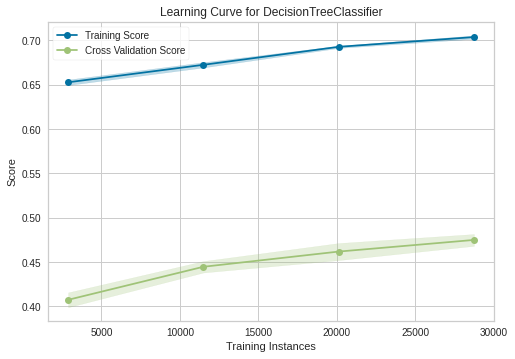

In [22]:
logger.info(f'Computing learning curve for {dt.clf_name}')
dt.plot_learning_curve()

As it can be seen from the above graph, there is a discrepancy between Training and validation score suggesting that the model is slightly overfitting but more importantly, the two curves are not diverging, hence the results are still acceptable. Also, both learning curves are increasing in number of training instances meaning that more data could potentially improve model performance further.

The graph below depicts the decision tree for the model.

2020-05-11 18:52:25,646 - pipeline - INFO - Plotting decision tree for Decision Tree


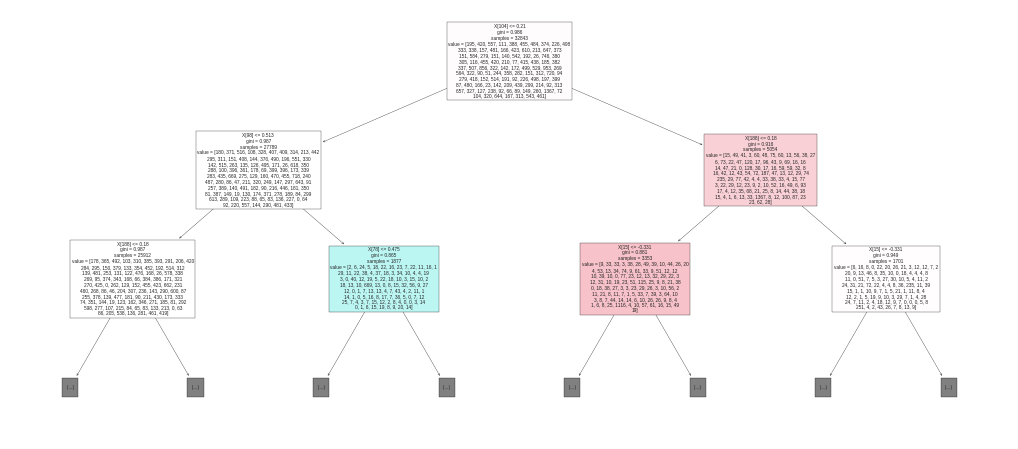

In [24]:
logger.info(f'Plotting decision tree for {dt.clf_name}')
dt.plot_dtree()

2020-05-11 18:52:26,152 - pipeline - INFO - Feature importances for Decision Tree


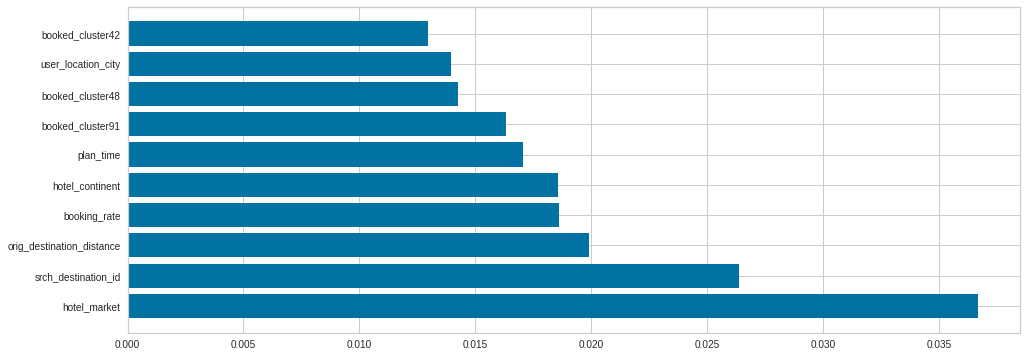

,importance
hotel_market,0.036676
srch_destination_id,0.026368
orig_destination_distance,0.019899
booking_rate,0.018591
hotel_continent,0.018576
plan_time,0.017048
booked_cluster91,0.016337
booked_cluster48,0.014258
user_location_city,0.013971
booked_cluster42,0.012946


In [25]:
logger.info(f'Feature importances for {dt.clf_name}')
dt.feature_importances(X_columns, top=10)

From the feature importances it is interesting to see that the top three features all concern the location as well as the origin destination distance. As was mentioned earlier, the location of the hotel and the user does seem to provide quite unique information. Additionally, a lot of our generated features are found in the top 10 features.

In [26]:
gs_dt = GridSearch(config, DecisionTree, X_train, y_train)
gs_dt.search()
gs_dt.print_best_results()

2020-05-11 18:54:58,575 - pipeline.run.grid_search - INFO - Check 36 combinations => 288 fits
2020-05-11 18:54:58,576 - pipeline.run.grid_search - INFO - Decision Tree: 1 / 36 comb | 0.463721697785778
2020-05-11 18:54:58,577 - pipeline.run.grid_search - INFO - Decision Tree: 2 / 36 comb | 0.4648482390821074
2020-05-11 18:54:58,578 - pipeline.run.grid_search - INFO - Decision Tree: 3 / 36 comb | 0.4699026868971049
2020-05-11 18:54:58,579 - pipeline.run.grid_search - INFO - Decision Tree: 4 / 36 comb | 0.47437808993463715
2020-05-11 18:54:58,580 - pipeline.run.grid_search - INFO - Decision Tree: 5 / 36 comb | 0.4747435498865924
2020-05-11 18:54:58,581 - pipeline.run.grid_search - INFO - Decision Tree: 6 / 36 comb | 0.47501759108354547
2020-05-11 18:54:58,582 - pipeline.run.grid_search - INFO - Decision Tree: 7 / 36 comb | 0.4820509319714532
2020-05-11 18:54:58,583 - pipeline.run.grid_search - INFO - Decision Tree: 8 / 36 comb | 0.4816855091001968
2020-05-11 18:54:58,584 - pipeline.run.gr

In [27]:
gs_dt.df_results

,criterion,max_depth,min_samples_leaf,min_samples_split,score
16,gini,NaN,6,4,0.482264
6,gini,100.0,6,2,0.482051
15,gini,NaN,6,2,0.481838
17,gini,NaN,6,6,0.481777
8,gini,100.0,6,6,0.481716
7,gini,100.0,6,4,0.481686
14,gini,NaN,4,6,0.475139
13,gini,NaN,4,4,0.475079
5,gini,100.0,4,6,0.475018
12,gini,NaN,4,2,0.474865


After grid search, we could only improve the score a little bit. But the picture is misleading as also the standard params have already been tuned according to past hyper parameter searches.

In [28]:
model_objects.append(dt)
grid_search_objects.append(gs_dt)

### 3.4.3 Neural Network

Next up, we trained a neural network, to see whether deep learning can improve the accuracy score. Neural networks can lean complex non linear realtionships and often require less preprocessing, but come at cost of lower interpratability.

In [29]:
class NeuralNetwork(BaseModel):
    name = 'Neural Network'
    def __init__(self, config, X, y, params=None):
        super().__init__(config, X, y, params)
        self.clf_name = 'NeuralNetwork'

    def get_default_model(self):
        """
        See base model
        """
        return KerasClassifier

    def get_default_parameter(self):
        """
        See base model
        """
        return {
            'build_fn': self.create_network,
            'epochs': 50,
            'batch_size': 128,
            'verbose': 0,
            'callbacks': EarlyStopping(monitor='acc', mode='max', verbose=0, patience=3)
        }

    def create_network(self):
        """
        Returns a compiled keras neural net
        """
        nn = models.Sequential()
        nn.add(layers.Dense(units=256,
                            input_shape=(self.X.shape[1],),
                           kernel_regularizer=l2(0.01)))
        nn.add(BatchNormalization())
        nn.add(Activation('relu'))
        nn.add(Dropout(0.5))
        nn.add(layers.Dense(units=128,
                           kernel_regularizer=l2(0.01)))
        nn.add(BatchNormalization())
        nn.add(Activation('relu'))
        nn.add(Dropout(0.5))
        nn.add(layers.Dense(units=64,
                           kernel_regularizer=l2(0.01)))
        nn.add(BatchNormalization())
        nn.add(Activation('relu'))
        nn.add(Dropout(0.5))
        nn.add(layers.Dense(units=len(pd.unique(self.y)),
                            activation='softmax'
                            ))
        nn.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['acc']
                   )
        return nn

    def plot_learning_curve(self, X_holdout, y_holdout):
        """
        Plots the learning curve based on the keras history
        """
        fig, ax = plt.subplots(1, 2, figsize=(14, 8))
        
        # need to fit keras model without scikit wrapper to provide val set
        params = self.get_default_parameter()
        del params['build_fn']
        self.clf.model.compile(loss='sparse_categorical_crossentropy',
                               optimizer='adam',
                               metrics=['acc'])
        history = self.clf.model.fit(self.X, self.y, validation_data=(X_holdout, y_holdout), **params)

        # Plot training & validation accuracy values
        ax[0].plot(history.history['acc'])
        ax[0].plot(history.history['val_acc'])
        ax[0].set_title('Model accuracy')
        ax[0].set_ylabel('Accuracy')
        ax[0].set_xlabel('Epoch')
        ax[0].legend(['Train', 'Test'], loc='upper left')

        # Plot training & validation loss values
        ax[1].plot(history.history['loss'])
        ax[1].plot(history.history['val_loss'])
        ax[1].set_title('Model loss')
        ax[1].set_ylabel('Loss')
        ax[1].set_xlabel('Epoch')
        ax[1].legend(['Train', 'Test'], loc='upper left')

        # fig.savefig(f'./plots/{self.clf_name}')
        plt.show()
    
    def train_model(self):        
        """
        Overwrite base model to store history
        """
        if self.clf is not None:
            self.history = self.clf.fit(self.X, self.y)
        else:
            raise Exception('Model not defined.')
            
    @staticmethod
    def make_nn(input_shape, output_shape):
        """
        Needed for grid search as keras expects a callable
        """
        def make_keras_sequence():
            nn = models.Sequential()
            nn.add(layers.Dense(units=256,
                                input_shape=(input_shape,),
                                kernel_regularizer=l2(0.01)
                                ))
            nn.add(BatchNormalization())
            nn.add(Activation('relu'))
            nn.add(Dropout(0.5))
            nn.add(layers.Dense(units=128,
                               kernel_regularizer=l2(0.01)))
            nn.add(BatchNormalization())
            nn.add(Activation('relu'))
            nn.add(Dropout(0.5))
            nn.add(layers.Dense(units=64,
                               kernel_regularizer=l2(0.01)))
            nn.add(BatchNormalization())
            nn.add(Activation('relu'))
            nn.add(Dropout(0.5))
            nn.add(layers.Dense(units=output_shape,
                                activation='softmax'
                                ))
            nn.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['acc']
                       )
            return nn
        return make_keras_sequence
    

    @staticmethod
    def get_grid_search_parameters(input_shape, output_shape):
        """
        See base model
        """
        nn = NeuralNetwork.make_nn(input_shape, output_shape)
        return [{
              'build_fn': [nn],
              'epochs': [10, 20],
              'batch_size': [32, 128],
              'verbose': [0]
          }]

In [30]:
nn = NeuralNetwork(config, X_train, y_train)
nn.train_model()

if config.getboolean('General', 'cross_validation'):
    nn.calc_cross_val_score()
else:
    preds_holdout = nn.predict(X_holdout)
    nn.score = accuracy_score(y_holdout, preds_holdout)

logger.info(f'{nn.clf_name} score: {nn.score}')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
2020-05-11 18:55:37,791 - tensorflow - WARNING - From /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/wrappers/scikit_learn.py:241: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
2020-05-11 18:55:38,016 - pipeline - INFO - NeuralNetwork

With a score of .47, the neural net cannot improve on the decision tree. The problem at hand again was the major tendency to overfit the training data. Therfore we had to regularize the model with Dropout, L2 kernel regularizers as well as by the use of early stopping. As can be seen from the learning history plotted below, even with strong regularization, we could only train the model for 8 epochs until Early stopping hit in. 

2020-05-11 18:55:38,022 - pipeline - INFO - Computing learning curve for NeuralNetwork


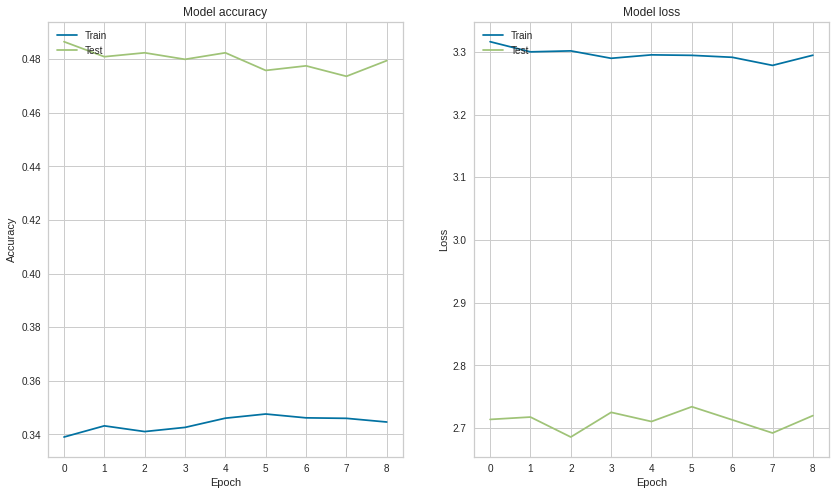

In [31]:
logger.info(f'Computing learning curve for {nn.clf_name}')
nn.plot_learning_curve(X_holdout, y_holdout)

In [32]:
# logger.info(f'Plotting confusion matrix for {nn.clf_name}')
# nn.confusion_matrix(X_holdout, y_holdout)

In [33]:
gs_nn = GridSearch(config, NeuralNetwork, X_train, y_train)
gs_nn.search()
gs_nn.print_best_results()

2020-05-11 18:56:42,290 - pipeline.run.grid_search - INFO - Neural Network: 1 / 4 comb | 0.43662287831657187
2020-05-11 18:58:17,652 - pipeline.run.grid_search - INFO - Neural Network: 2 / 4 comb | 0.4486503293062706
2020-05-11 18:58:41,758 - pipeline.run.grid_search - INFO - Neural Network: 3 / 4 comb | 0.48384775139675573
2020-05-11 18:59:24,594 - pipeline.run.grid_search - INFO - Neural Network: 4 / 4 comb | 0.4909117728549113
2020-05-11 18:59:24,599 - pipeline.run.grid_search - INFO - Best Grid Search | Neural Network: 0.4909117728549113


In [34]:
gs_nn.df_results

,batch_size,build_fn,epochs,verbose,score
3,128,<function NeuralNetwork.make_nn.<locals>.make_...,20,0,0.490912
2,128,<function NeuralNetwork.make_nn.<locals>.make_...,10,0,0.483848
1,32,<function NeuralNetwork.make_nn.<locals>.make_...,20,0,0.448650
0,32,<function NeuralNetwork.make_nn.<locals>.make_...,10,0,0.436623


When performing grid search it is not possible to use an early stopping call back. Hence also the number of epochs can be tuned. It can be seen that we managed to improve the score to 49% by training for more epochs. This might indicate, that given the low patience used in the Early stopping callback earlier, we might be able to generate a better score by simply training longer. We think that by continuing to search for reasonable hyperparameters and improving the neural net architecture, it certainly might be possible to improve further but given the generally low improvement over a simple decsision tree, while losing interpratability, we will continue to look for other models.

In [35]:
model_objects.append(nn)
grid_search_objects.append(gs_nn)

### 3.4.4 Random Forest
Next we will try a random forest which is expected to incrase and build upon the performance of a simple decision tree trained earlier.

In [59]:
class RandomForest(BaseModel):
    name = 'Random Forest'
    def __init__(self, config, X, y, params=None):
        super().__init__(config, X, y, params)
        self.clf_name = 'Random Forest'

    def get_default_model(self):
        """
        See base model
        """
        return RandomForestClassifier

    def get_default_parameter(self):
        """
        See base model
        """
        return {'random_state': 420,
                'criterion': 'gini',
                'min_samples_split': 4,
                'min_samples_leaf': 4,
                'max_depth': 50
               }

    @staticmethod
    def get_grid_search_parameters():
        """
        See base model
        """
        return [{#'bootstrap': [True, False],
                 'max_depth': [50, 70],
                 'min_samples_split': [4, 10],
                 'min_samples_leaf': [2, 4, 10],
                 }]

In [42]:
rf = RandomForest(config, X_train, y_train)
rf.train_model()

if config.getboolean('General', 'cross_validation'):
    rf.calc_cross_val_score()
else:
    preds_holdout = rf.predict(X_holdout)
    rf.score = accuracy_score(y_holdout, preds_holdout)

logger.info(f'{rf.clf_name} score: {rf.score}')

2020-05-11 19:09:58,735 - pipeline - INFO - Random Forest score: 0.5390986601705238


The random forest classifier provides a huge improvement over the past models. By using bagging as well as subsetting the feature space the random forest classifier generates a validation score of 54%. In addition, also the learning curve plotted below looks the best from what we have looked at so far. The training and valiadtion scores approach each other continously. We achieve this result by restricting the individual trees with a similar parameter choice as deployed for the simple descision trees earlier. In addition we also set the max depth to help regularize the model.

2020-05-11 19:09:58,741 - pipeline - INFO - Computing learning curve for Random Forest


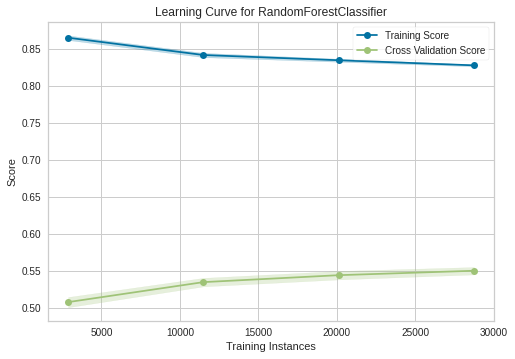

In [43]:
logger.info(f'Computing learning curve for {rf.clf_name}')
rf.plot_learning_curve()

2020-05-11 19:10:38,180 - pipeline - INFO - Feature importances for Random Forest


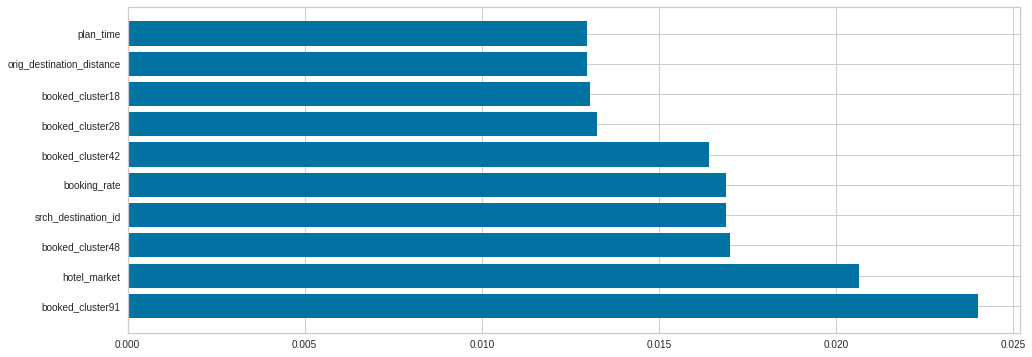

,importance
booked_cluster91,0.024005
hotel_market,0.020649
booked_cluster48,0.017013
srch_destination_id,0.016908
booking_rate,0.016899
booked_cluster42,0.016408
booked_cluster28,0.013261
booked_cluster18,0.013054
orig_destination_distance,0.012980
plan_time,0.012975


In [44]:
logger.info(f'Feature importances for {rf.clf_name}')
rf.feature_importances(X_columns, top=10)

When looking at the top 10 most important features we find that there are the origin destination distance, the search destination id and the hotel market, all relating to the location of the hotel. Why these feature might be important has been explained earlier. More importantly, all other features have been generated by us, this includes all booked clusters but also the booking rate as well as the plan time.

In [60]:
gs_rf = GridSearch(config, RandomForest, X_train, y_train)
gs_rf.search()
gs_rf.print_best_results()

2020-05-11 21:14:02,078 - pipeline.run.grid_search - INFO - Check 12 combinations => 96 fits
2020-05-11 21:14:02,080 - pipeline.run.grid_search - INFO - Random Forest: 1 / 12 comb | 0.5482753247824252
2020-05-11 21:14:02,081 - pipeline.run.grid_search - INFO - Random Forest: 2 / 12 comb | 0.5532993664243469
2020-05-11 21:14:02,081 - pipeline.run.grid_search - INFO - Random Forest: 3 / 12 comb | 0.5527508687266132
2020-05-11 21:14:02,082 - pipeline.run.grid_search - INFO - Random Forest: 4 / 12 comb | 0.5534209762843716
2020-05-11 21:14:02,082 - pipeline.run.grid_search - INFO - Random Forest: 5 / 12 comb | 0.5437993210375713
2020-05-11 21:14:02,083 - pipeline.run.grid_search - INFO - Random Forest: 6 / 12 comb | 0.5455654153957875
2020-05-11 21:14:02,083 - pipeline.run.grid_search - INFO - Random Forest: 7 / 12 comb | 0.5508940527305337
2020-05-11 21:14:02,084 - pipeline.run.grid_search - INFO - Random Forest: 8 / 12 comb | 0.55427373594864
2020-05-11 21:14:02,084 - pipeline.run.grid_s

In [61]:
gs_rf.df_results

,max_depth,min_samples_leaf,min_samples_split,score
7,70,2,10,0.554274
8,70,4,4,0.553452
3,50,4,10,0.553421
1,50,2,10,0.553299
2,50,4,4,0.552751
9,70,4,10,0.552721
6,70,2,4,0.550894
0,50,2,4,0.548275
11,70,10,10,0.545870
5,50,10,10,0.545565


Using hyperparamter search, we were able to bump up the accuracy annother percent to 55%.

In [62]:
model_objects.append(rf)
grid_search_objects.append(gs_rf)

### 3.4.5 XGBoost
XGBoost has been shown to often outperform bagging models like random forests, and also often works better than neural nets for tabular data. XGBoost is a gradient boosting model. An advantage is also the possibility to use a softmax objective so that we do not need to train multiple models

In [51]:
class XGBoost(BaseModel):
    name = 'XGBoost'
    def __init__(self, config, X, y, params=None):
        super().__init__(config, X, y, params)
        self.clf_name = 'XGB Boost'
        self.config = config

    def get_default_model(self):
        """
        See base model
        """
        return XGBClassifier

    def get_default_parameter(self):
        """
        Defaults to objective='binary:logistic' and One vs rest
        """
        return {'n_jobs': -1,
                'max_depth': 3,
                'min_child_weight': 4,
                'n_estimators': 20,
                #'gamma': 0,
                'objective': 'multi:softmax',
                'eta': .3,
                }

    def train_model(self):
        """
        Overwrite base model to use early stopping with validation set
        """
        if self.clf is not None:
            self.clf.fit(self.X,
                         self.y,
                         eval_set=[(self.X, self.y)],
                         early_stopping_rounds=5,
                         verbose=False)
        else:
            raise Exception('Model not defined.')

    @staticmethod
    def get_grid_search_parameters():
        """
        See base model
        """
        return [{
                 'max_depth': [3],
                 'min_child_weight': [4, 2],
                 'n_estimators': [30],
                 'objective': ['multi:softmax'],
                 'eta': [.3, .2] 
                }]
    
    def plot_learning_curve(self, X_holdout, y_holdout):
        """
        Plot learning curve based on validation data
        """
        eval_set = [(self.X, self.y), (X_holdout, y_holdout)]
        self.clf.fit(self.X, self.y, 
                     eval_metric=["merror"], 
                     eval_set=eval_set,
                     early_stopping_rounds=5,
                     verbose=False)
        results = self.clf.evals_result()
        epochs = len(results['validation_0']['merror'])
        x_axis = range(0, epochs)
        
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        
        ax.plot(x_axis, results['validation_0']['merror'], label='Train')
        ax.plot(x_axis, results['validation_1']['merror'], label='Test')
        ax.legend()
        ax.set_ylabel('merror')
        ax.set_title('merror')
        
        # fig.savefig(f'./plots/{self.clf_name}')
        plt.show()

In [52]:
xgb = XGBoost(config, X_train, y_train)
xgb.train_model()

if config.getboolean('General', 'cross_validation'):
    xgb.calc_cross_val_score()
else:
    preds_holdout = xgb.predict(X_holdout)
    xgb.score = accuracy_score(y_holdout, preds_holdout)

logger.info(f'{xgb.clf_name} score: {xgb.score}')

2020-05-11 20:39:42,454 - pipeline - INFO - XGB Boost score: 0.5856272838002436


Once again, for XGBoost or gradient boosting, we were especially concerned regarding overfitting. To find the right number of estimators, we used early stopping as well as a max bound of 30. As can be seen from the learning curve below, when using about 18 trees, early stopping hits. Furthermore, we also set the max depth as well as min child weight for individual trees. The score on the validation set is 58%, outperforming all other models we looked at.

2020-05-11 20:39:42,462 - pipeline - INFO - Computing learning curve for XGB Boost


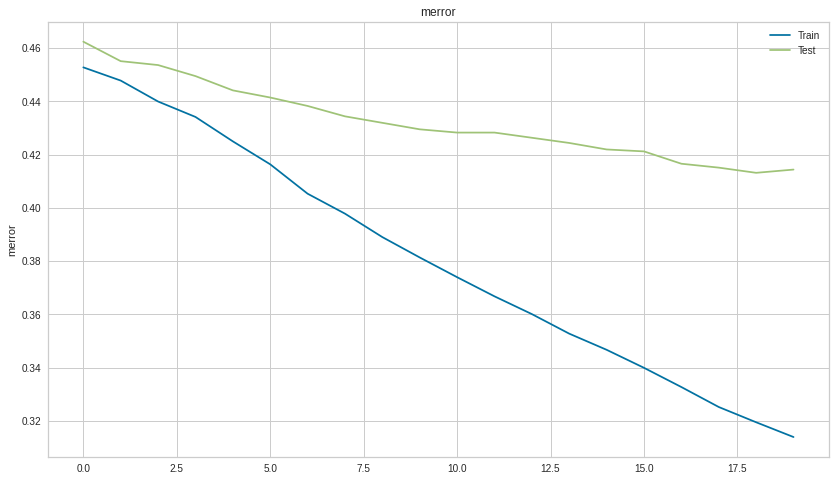

In [53]:
logger.info(f'Computing learning curve for {xgb.clf_name}')
xgb.plot_learning_curve(X_holdout, y_holdout)

2020-05-11 20:45:02,669 - pipeline - INFO - Feature importances for XGB Boost


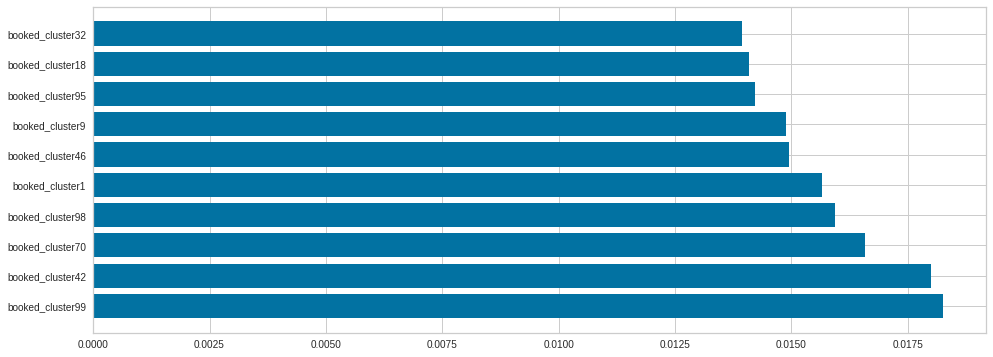

,importance
booked_cluster99,0.018271
booked_cluster42,0.018002
booked_cluster70,0.016582
booked_cluster98,0.015943
booked_cluster1,0.015664
booked_cluster46,0.014942
booked_cluster9,0.014877
booked_cluster95,0.014231
booked_cluster18,0.014092
booked_cluster32,0.013946


In [54]:
logger.info(f'Feature importances for {xgb.clf_name}')
xgb.feature_importances(X_columns, top=10)

From the feature importances, we can see that all the top 10 most important feature concern the number of booked clusters previuosly, hence the booking history. This fits in very well with Expedia's business goal to improve the search algorithm by taking into consideration user specific data and not only search hyperparamters.

In [55]:
gs_xgb = GridSearch(config, XGBoost, X_train, y_train)
gs_xgb.search()
gs_xgb.print_best_results()

2020-05-11 21:06:02,110 - pipeline.run.grid_search - INFO - Check 4 combinations => 32 fits
2020-05-11 21:06:02,113 - pipeline.run.grid_search - INFO - XGBoost: 1 / 4 comb | 0.6002806193129333
2020-05-11 21:06:02,114 - pipeline.run.grid_search - INFO - XGBoost: 2 / 4 comb | 0.6017115931470123
2020-05-11 21:06:02,115 - pipeline.run.grid_search - INFO - XGBoost: 3 / 4 comb | 0.5893498151601323
2020-05-11 21:06:02,116 - pipeline.run.grid_search - INFO - XGBoost: 4 / 4 comb | 0.5921510023951165
2020-05-11 21:06:02,126 - pipeline.run.grid_search - INFO - Best Grid Search | XGBoost: 0.6017115931470123


In [56]:
gs_xgb.df_results

,eta,max_depth,min_child_weight,n_estimators,objective,score
1,0.3,3,2,30,multi:softmax,0.601712
0,0.3,3,4,30,multi:softmax,0.600281
3,0.2,3,2,30,multi:softmax,0.592151
2,0.2,3,4,30,multi:softmax,0.589350


Using grid search, we we able to improve the score by annother 2% to a cross val score of 60%

In [57]:
model_objects.append(xgb)
grid_search_objects.append(gs_xgb)

### 4. Conclusion / Compare models

To decide which model has worked the best, we aggregate all the validation set scores in a DataFrame.

In [63]:
# compare scores with default params
if config.getboolean('General', 'cross_validation'):
    results = pd.DataFrame([(m.clf_name, m.score,) for m in model_objects], 
                           columns=['Model', 'CV score'])
    results.sort_values(by=['CV score'], ascending=False, inplace=True)
else:
    results = pd.DataFrame([(m.clf_name, m.score,) for m in model_objects], 
                           columns=['Model', 'Validation set score'])
    results.sort_values(by=['Validation set score'], ascending=False, inplace=True)
results

,Model,Validation set score
3,XGB Boost,0.585627
4,Random Forest,0.539099
1,Decision Tree,0.479903
2,NeuralNetwork,0.475274
0,Benchmark,0.151279


Using grid search, we were able to bump up the scores a little bit. The numbers need to be handled with caution as we the grid search scores are cross validation scores and the scores above validation set scores. Therfore, we take the best models from grid search, train the on the full data set and generate a validation set scores by which we sort the df below.

In [64]:
for gso in grid_search_objects:
    gso.model.name
    model = gso.get_best_model()
    gso.model = model
    preds = model.predict(X_holdout)
    vs = accuracy_score(y_holdout, preds)
    gso.val_score = vs

In [65]:
results_gs = pd.DataFrame([(gso.model.name, tuple(gso.get_best_result())[1], gso.val_score) for gso in grid_search_objects], 
                          columns=['Name', 'Best GS score', 'Validation score'])

results_gs.sort_values(by=['Validation score'], ascending=False, inplace=True)
results_gs

,Name,Best GS score,Validation score
2,XGBoost,0.601712,0.597564
3,Random Forest,0.554274,0.548356
0,Decision Tree,0.482264,0.486967
1,Neural Network,0.490912,0.484044


Finally, we are going to evaluate the best model after grid search, XGBoost

In [66]:
resultgsm = [(gso.model.name, gso.val_score, gso.model) for gso in grid_search_objects]
best = max(resultgsm, key=lambda i: i[1])
best_model = best[-1]
logger.info(f'Best model: {best[0]}')

2020-05-11 21:23:25,042 - pipeline - INFO - Best model: XGBoost


In [68]:
preds_test = best_model.predict(X_test)
test_score = accuracy_score(y_test, preds_test)
logger.info(f'Final test score with {best[0]}: {test_score}')

2020-05-11 21:25:06,800 - pipeline - INFO - Final test score with XGBoost: 0.590842669264491


Best model we found is XGBoost with a 0.59 accuracy score on the test set.

The developed model will certaintly help Expedia increase their conversion rate by providing them with more suitable hotel recommendations. We found that leveraging the user history in hotel recommendations is very helpful. In particular, the best model XGBoost assigns the highest feature importances to past booking numbers.<br>
In the future, we recomemnd Expedia that with each search query entered on the Expedia website, they call an API to generate to get a prediction for the most likely hotel cluster booked using our XGBoost model. <br>
We are certain, that going forward, by presenting customers with individual recommendations based on their taste and past behaviour, Expedia will be able to increase their conversion rate significantly.